# Stock prediction: 1D convolution

In [122]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

from tensorflow.keras.utils import plot_model

sys.path.append('../')
from utils import *

# for Robust location estimation
from statsmodels import robust
import statsmodels.api as sm
from astropy.stats import biweight_location

tf.random.set_seed(25)

In [2]:
prices = pd.read_csv("../data/SX5E/close_mat.csv")
composition = pd.read_csv("../data/SX5E/SX5E Index_compositionMat.csv")
capitalization = pd.read_csv("../data/SX5E/capitalization_mat.csv")

prices = setup_tables(prices)
composition = setup_tables(composition)
capitalization = setup_tables(capitalization)

prices.set_index("Date", drop=True, inplace=True)
composition.set_index("Date", drop=True, inplace=True)
capitalization.set_index("Date", drop=True, inplace=True)

prices = select_time_slice(prices, start=20140101, end=20181231)
capitalization = select_time_slice(capitalization, start=20140101, end=20181231)
composition = select_time_slice(composition, start=20140101, end=20181231)

In [3]:
stocks = get_full_time_stock_in_period(composition.iloc[:, 1:])
print("Number of stocks =", len(stocks))

Number of stocks = 40


In [4]:
trading_days = get_trading_dates(start_period="2014-01-01", end_period="2018-12-31", market="EUREX")
print("Total number of trading days =", len(trading_days))

Total number of trading days = 1272


In [5]:
prices = prices[stocks].loc[trading_days]
capitalization = capitalization[stocks].loc[trading_days]
composition = composition[stocks].loc[trading_days]

## Example

In [6]:
returns = price_to_returns(prices, log=False, drop_na=True)
days = returns.index

We will use returns time series.

### Split train and test

In [7]:
# From pandas to numpy
returns = returns.to_numpy()
print(returns.shape)

(1271, 40)


In [8]:
def split_data(x: np.array, train_size: float = 0.8):
    index = int(len(x) * 0.8)
    train = x[: index ]
    test = x[index: ]
    return train, test

In [9]:
ret_train, ret_test = split_data(returns)
days_train = days[: len(ret_train)]
days_test = days[len(ret_train): ]

In [10]:
ret_train.T.shape

(40, 1016)

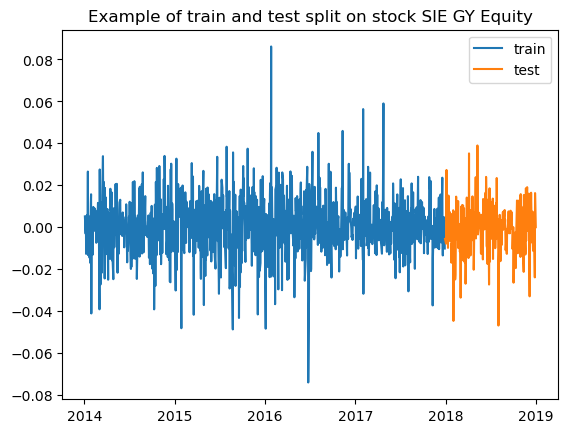

In [11]:
fig, ax = plt.subplots()

stock_index = 20

ax.plot(days_train, ret_train.T[stock_index], label="train")
ax.plot(days_test, ret_test.T[stock_index], label="test")
ax.set_title("Example of train and test split on stock " + prices.columns[stock_index])
ax.legend()
plt.show()

### Create train set

In [12]:
ret_train.shape

(1016, 40)

In [13]:
LOOK_BACK = 20
FORECAST_HORIZON = 1
N_STOCKS = 40


X_train, y_train = split_sequence(ret_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_HORIZON)
print("X_train.shape =", X_train.shape)
print("X_train.shape =", y_train.shape)

X_train.shape = (996, 20, 40)
X_train.shape = (996, 1, 40)


### Define model

In [95]:
model1 = Sequential(name='CNN-LSTM')
model1.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, N_STOCKS)))
model1.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(RepeatVector(FORECAST_HORIZON))
model1.add(LSTM(200, activation='relu', return_sequences=True))
model1.add(TimeDistributed(Dense(100, activation='relu')))
model1.add(TimeDistributed(Dense(N_STOCKS)))
model1.compile(loss='mse', optimizer='adam')

In [96]:
model1.summary()

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 12, 64)            23104     
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 64)             20544     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 1, 256)            0         
 tor)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 1, 200)            365

In [97]:
history = model1.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
32/32 [==============================] - 6s 13ms/step - loss: 2.4876e-04
Epoch 2/200
32/32 [==============================] - 0s 13ms/step - loss: 2.4752e-04
Epoch 3/200
32/32 [==============================] - 0s 13ms/step - loss: 2.4739e-04
Epoch 4/200
32/32 [==============================] - 0s 14ms/step - loss: 2.4969e-04
Epoch 5/200
32/32 [==============================] - 0s 15ms/step - loss: 2.4686e-04
Epoch 6/200
32/32 [==============================] - 1s 17ms/step - loss: 2.4814e-04
Epoch 7/200
32/32 [==============================] - 0s 15ms/step - loss: 2.4721e-04
Epoch 8/200
32/32 [==============================] - 0s 14ms/step - loss: 2.4621e-04
Epoch 9/200
32/32 [==============================] - 0s 15ms/step - loss: 2.4466e-04
Epoch 10/200
32/32 [==============================] - 1s 16ms/step - loss: 2.4256e-04
Epoch 11/200
32/32 [==============================] - 0s 14ms/step - loss: 2.3545e-04
Epoch 12/200
32/32 [==============================] - 0s 13ms/s

<Axes: >

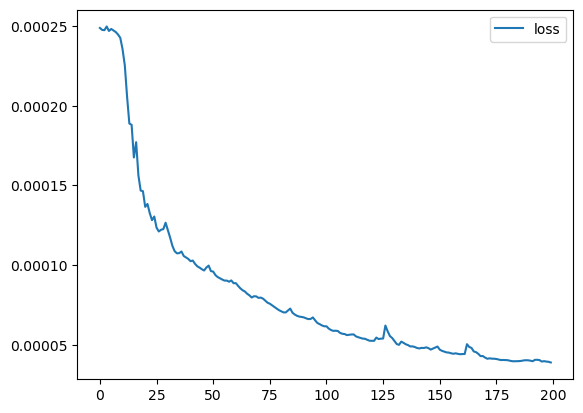

In [98]:
pd.DataFrame(history.history).plot()

In [99]:
train_predictions = model1.predict(X_train)

32/32 [==============================] - 1s 9ms/step


In [100]:
train_predictions = train_predictions.reshape(996, 40)

In [101]:
train_days = days_train[LOOK_BACK-1: ]

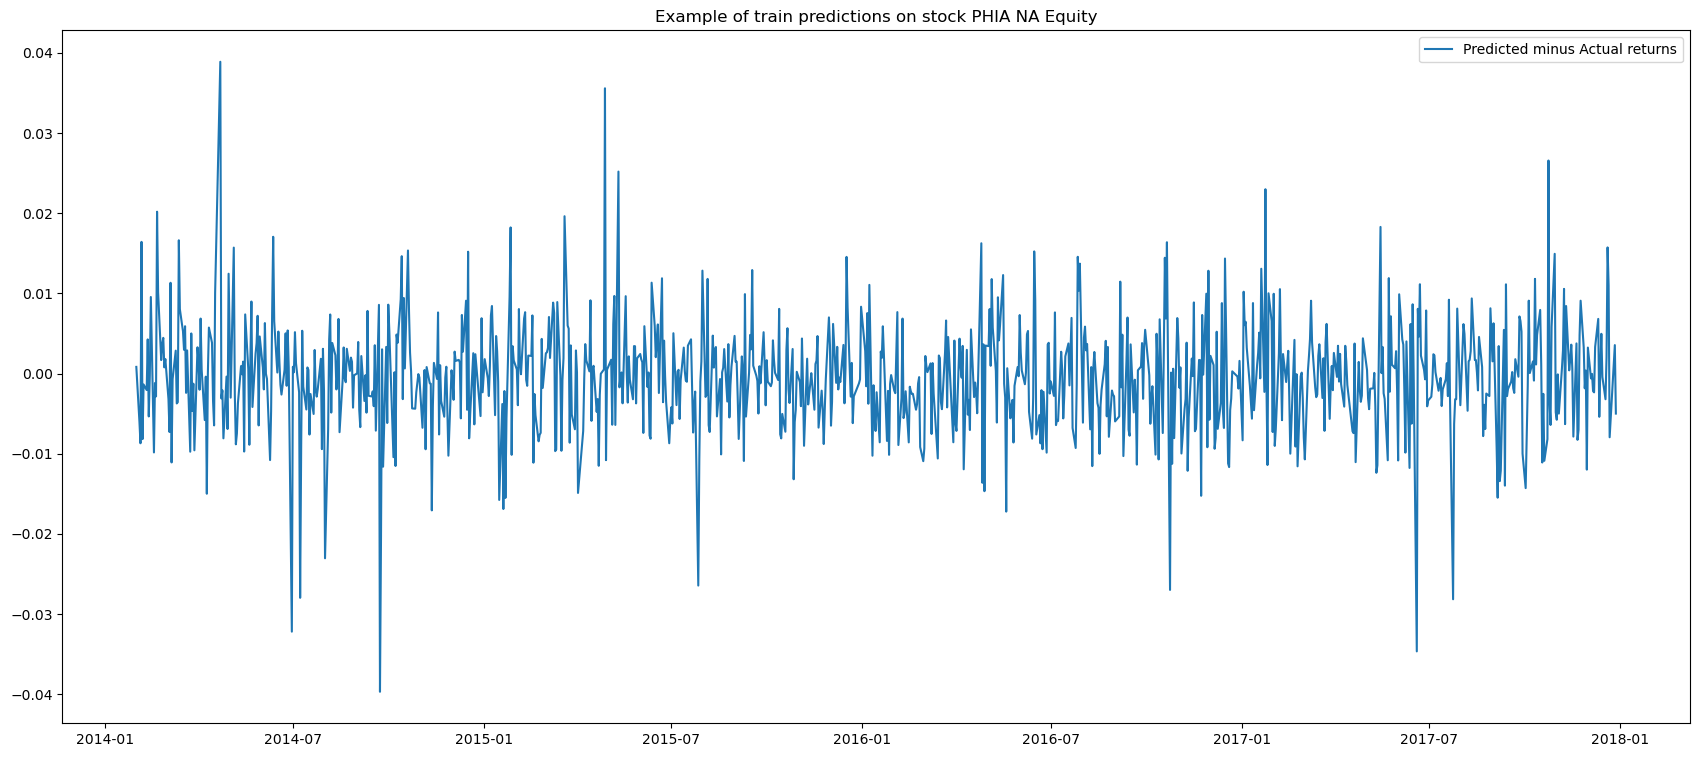

In [131]:
fig, ax = plt.subplots(figsize=(21, 9))

stock_index = 4

#ax.plot(train_days[1:], ret_train.T[stock_index][LOOK_BACK: ], label="Actual", alpha=0.5)
#ax.plot(train_days[1:], train_predictions.T[stock_index], label="Predicted", alpha=0.5)
ax.plot(train_days[1:], train_predictions.T[stock_index] - ret_train.T[stock_index][LOOK_BACK: ], label="Predicted minus Actual returns")

#ax.plot(days_test, ret_test.T[stock_index], label="test")
ax.set_title("Example of train predictions on stock " + prices.columns[stock_index])
ax.legend()
plt.show()

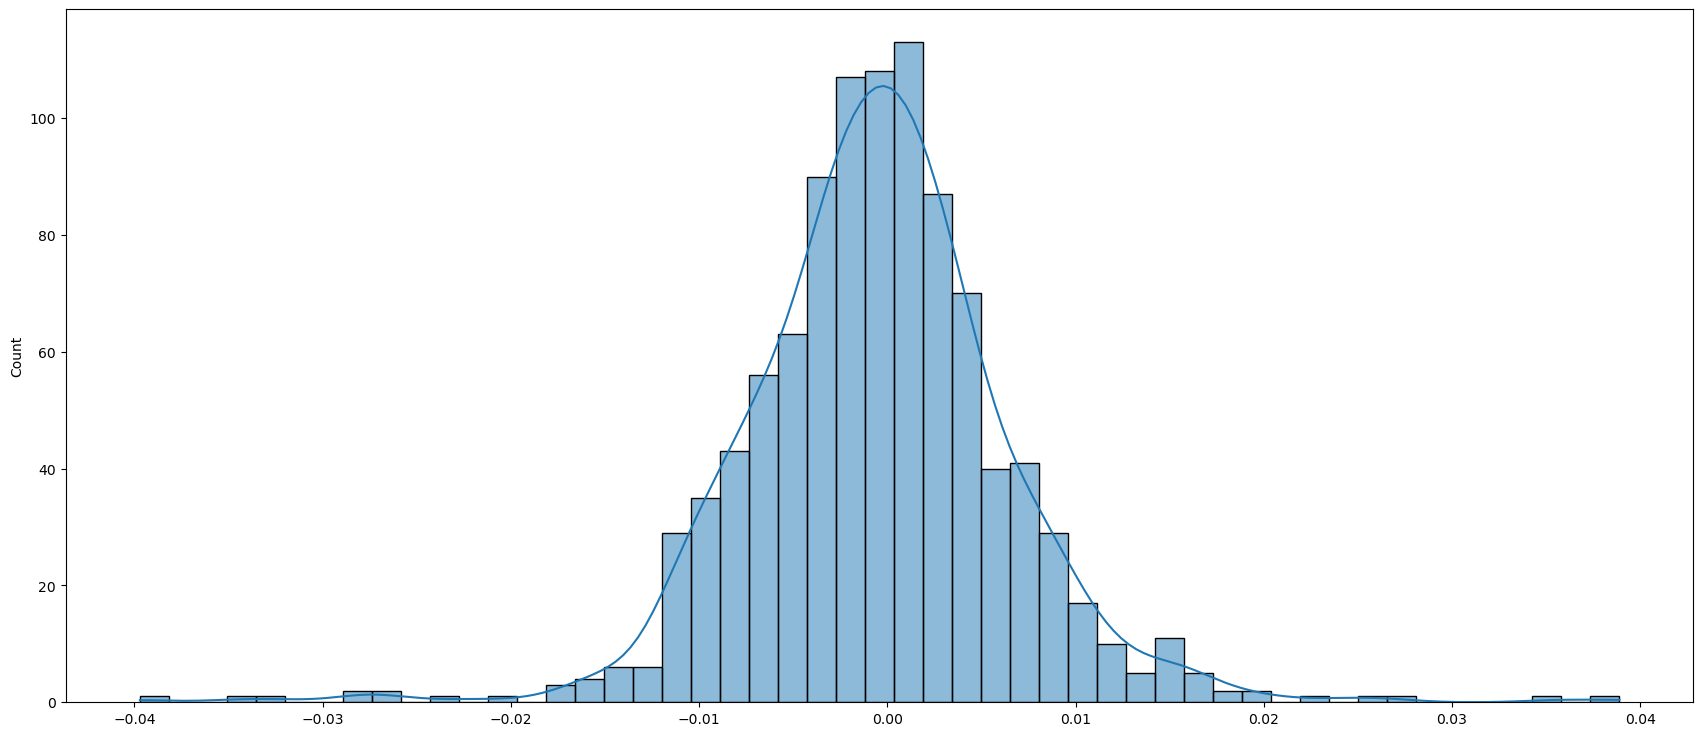

In [132]:
fig, ax = plt.subplots(figsize=(21, 9))

sns.histplot(train_predictions.T[stock_index] - ret_train.T[stock_index][LOOK_BACK: ], kde=True, ax=ax)

plt.show()

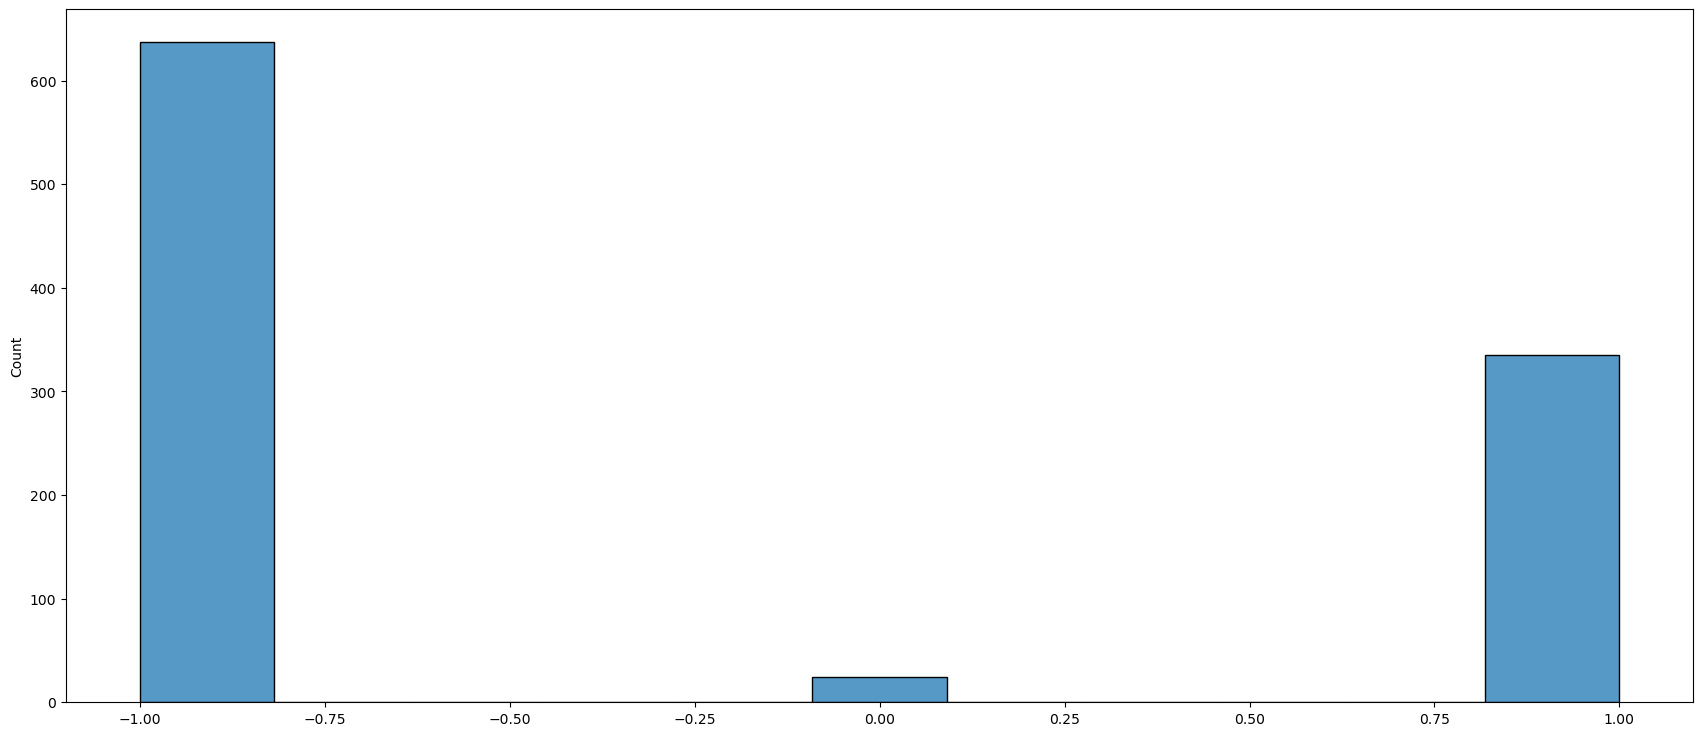

In [139]:
fig, ax = plt.subplots(figsize=(21, 9))

sns.histplot(np.sign((train_predictions.T[stock_index] - ret_train.T[stock_index][LOOK_BACK: ]) * ret_train.T[stock_index][LOOK_BACK: ]),
             ax=ax)

plt.show()

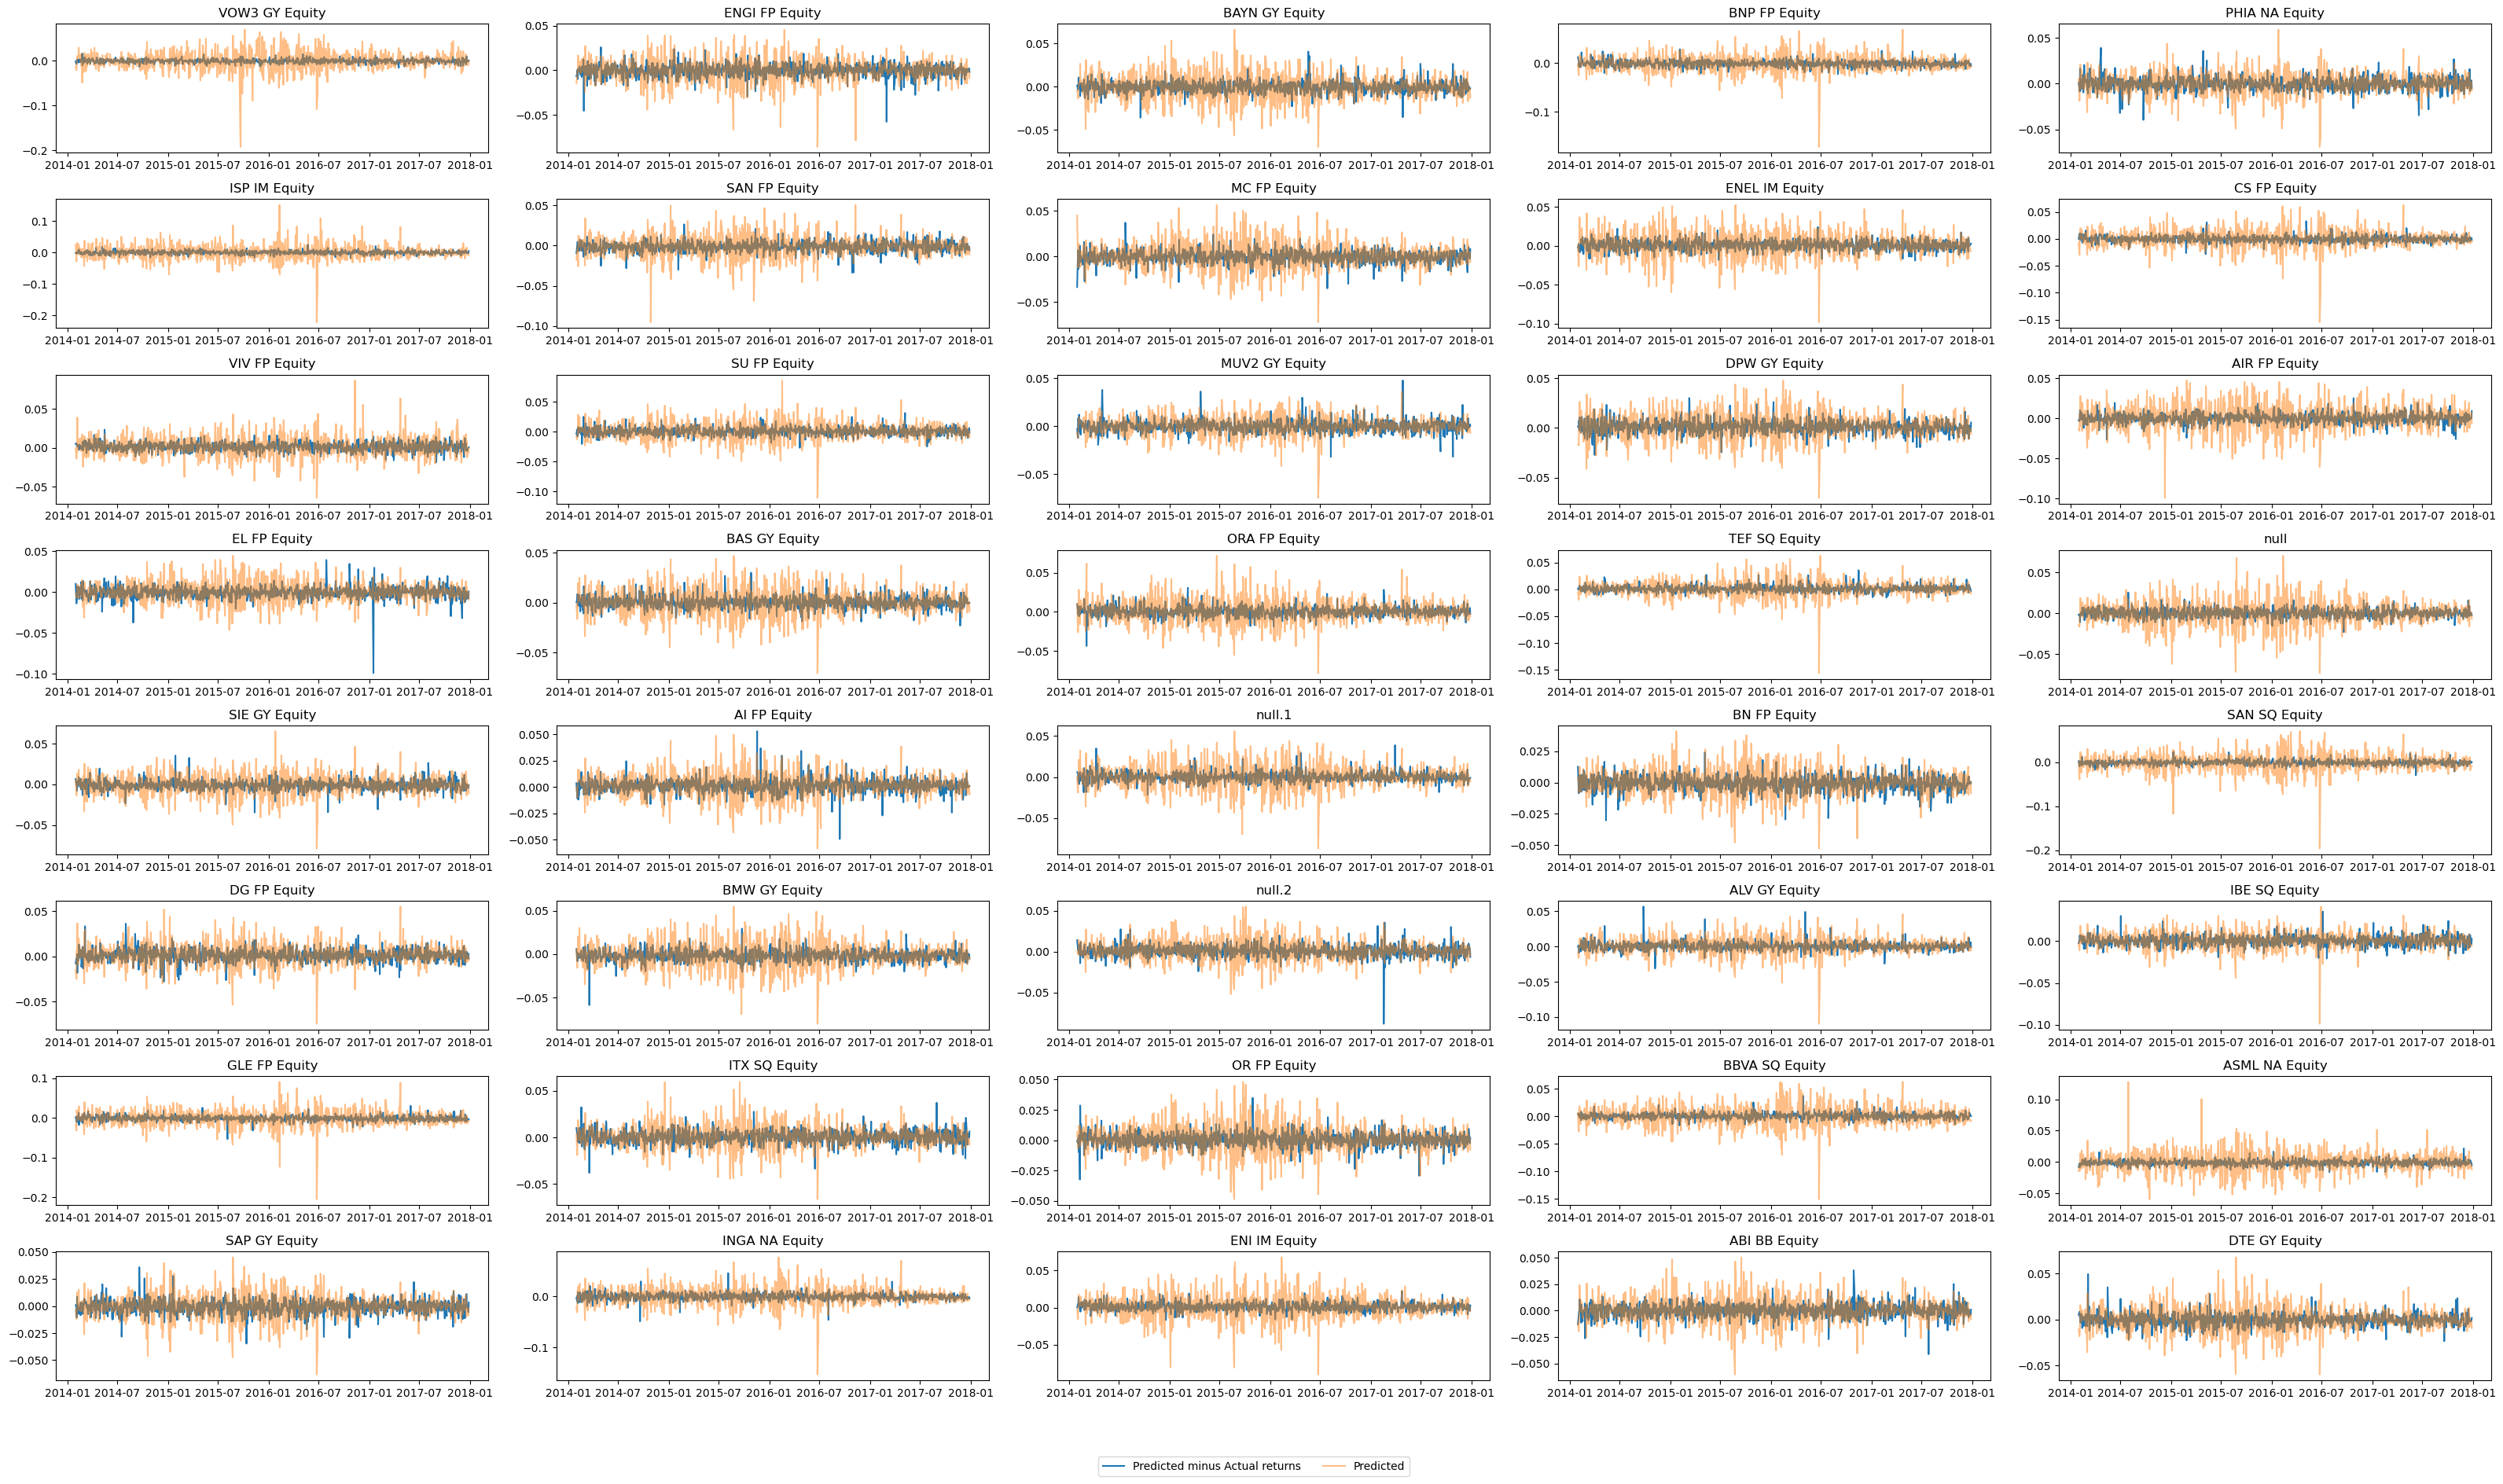

In [162]:
fig, axes = plt.subplots(8, 5, figsize=(32, 18), tight_layout=True)

for i in range(40):
    stock_index = i
    ax = axes[i // 5, i % 5]
    
    ax.plot(train_days[1:], train_predictions.T[stock_index] - ret_train.T[stock_index][LOOK_BACK: ], label="Predicted minus Actual returns")
    ax.plot(train_days[1:], train_predictions.T[stock_index], label="Predicted", alpha=0.5)
    
    #ax.axhline(y=0, color="red", label="y=0")
    ax.set_title(prices.columns[stock_index])

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

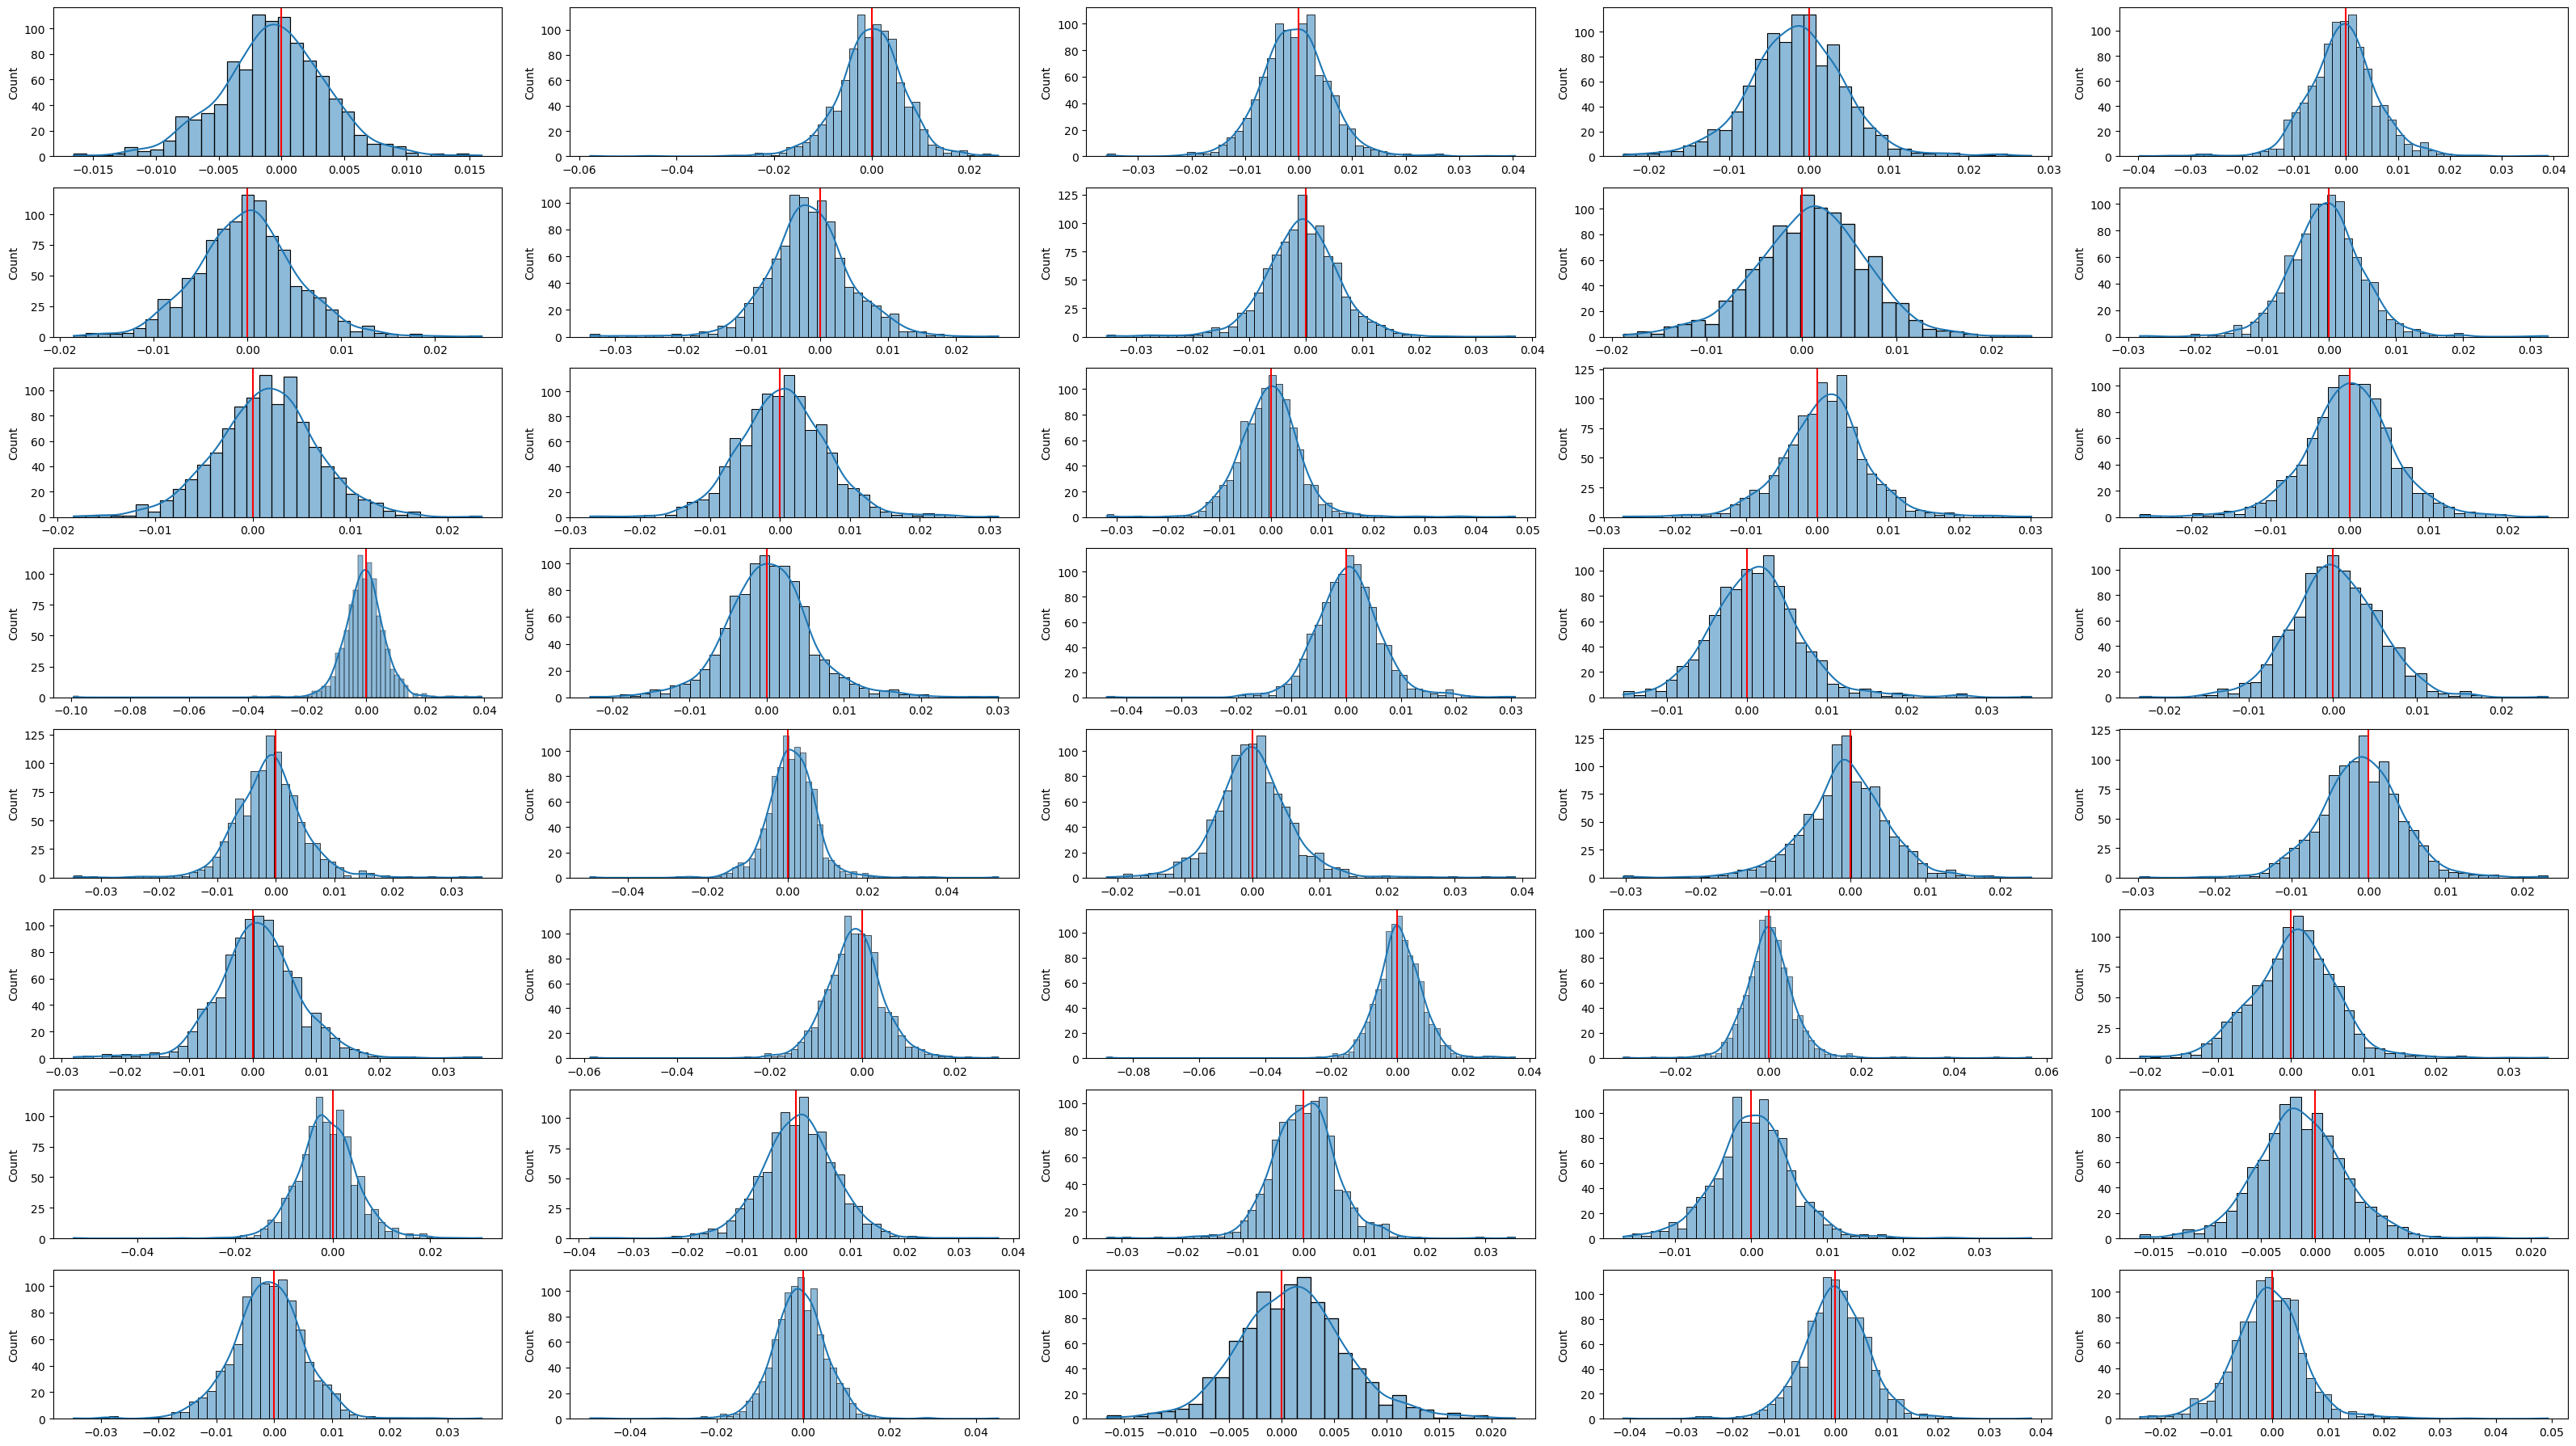

In [135]:
fig, axes = plt.subplots(8, 5, figsize=(32, 18), tight_layout=True)

for i in range(40):
    stock_index = i
    ax = axes[i // 5, i % 5]

    sns.histplot(train_predictions.T[stock_index] - ret_train.T[stock_index][LOOK_BACK: ], kde=True, ax=ax)
    ax.axvline(x=0, color="red", label="x=0")
#handles, labels = axes[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

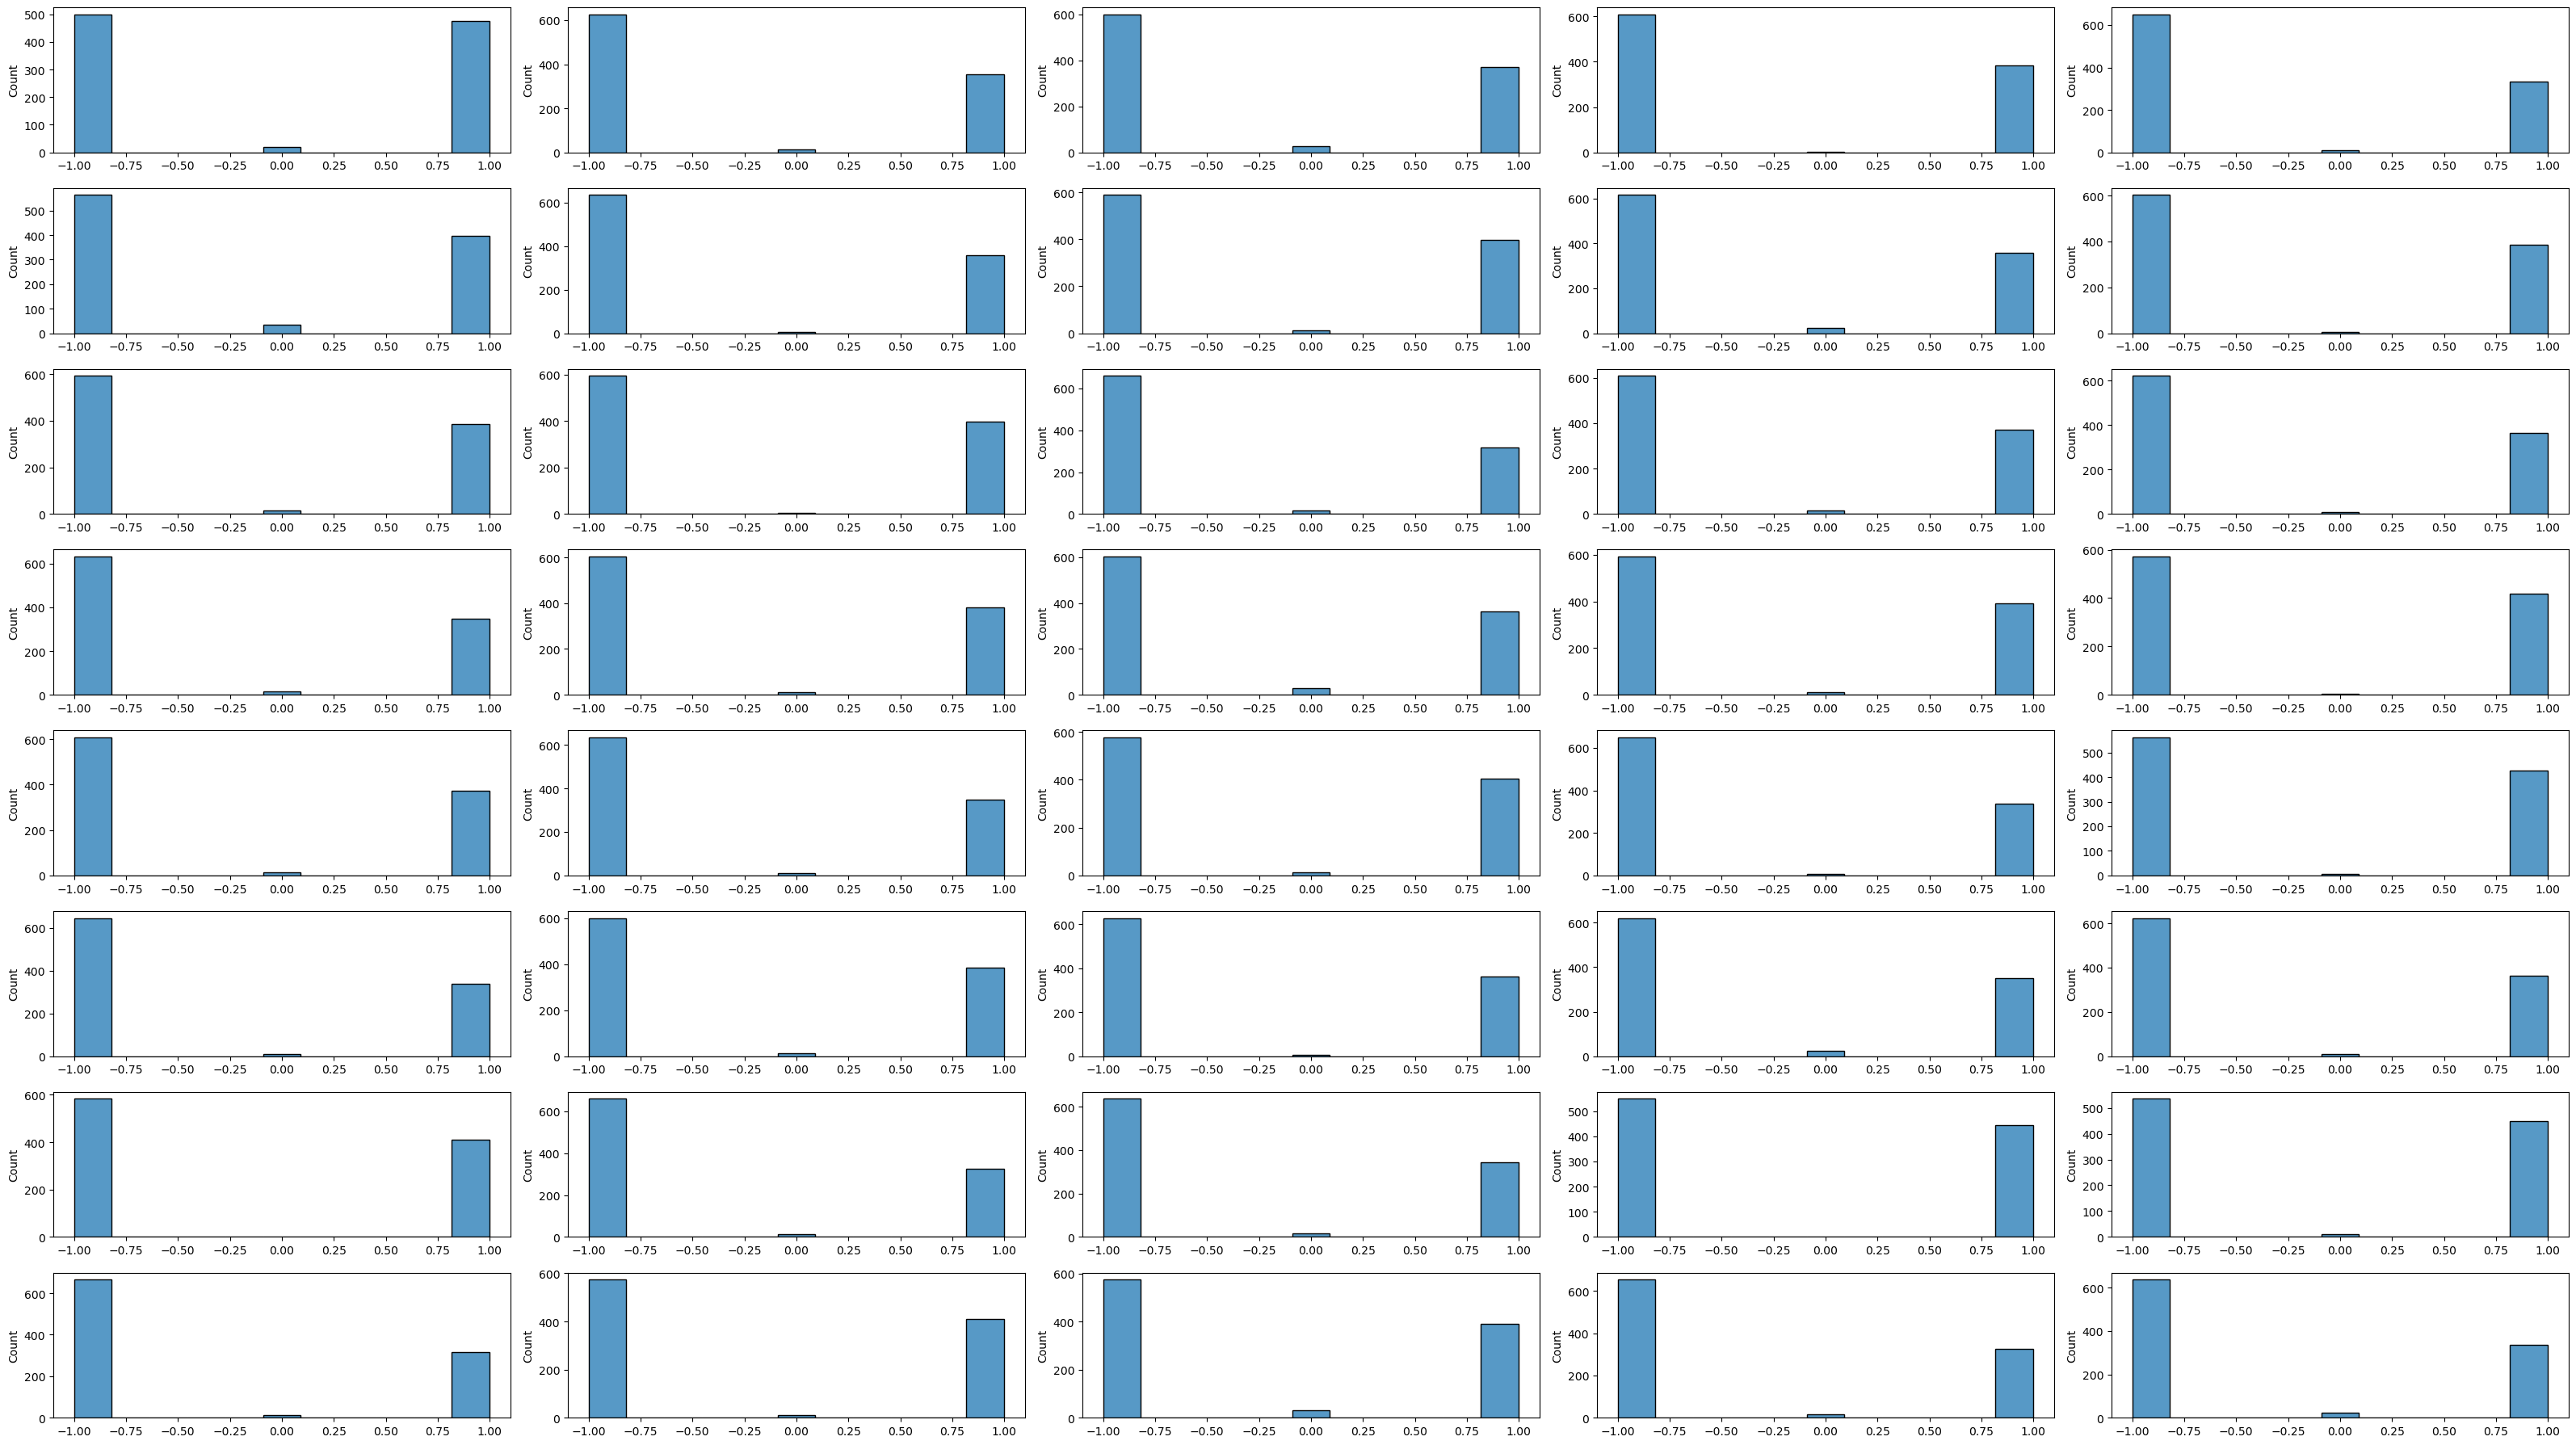

In [144]:
fig, axes = plt.subplots(8, 5, figsize=(32, 18), tight_layout=True)

for i in range(40):
    stock_index = i
    ax = axes[i // 5, i % 5]

    sns.histplot(np.sign((train_predictions.T[stock_index] - ret_train.T[stock_index][LOOK_BACK: ]) * ret_train.T[stock_index][LOOK_BACK: ]),
                ax=ax)
#handles, labels = axes[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

# Test

In [146]:
X_test, y_test = split_sequence(ret_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_HORIZON)
print("X_test.shape =", X_test.shape)
print("X_test.shape =", y_test.shape)

X_test.shape = (235, 20, 40)
X_test.shape = (235, 1, 40)


In [147]:
test_predictions = model1.predict(X_test)

8/8 [==============================] - 0s 10ms/step


In [152]:
test_predictions = test_predictions.reshape(235, 40)

In [148]:
test_days = days_test[LOOK_BACK-1: ]

In [149]:
len(test_days)

236

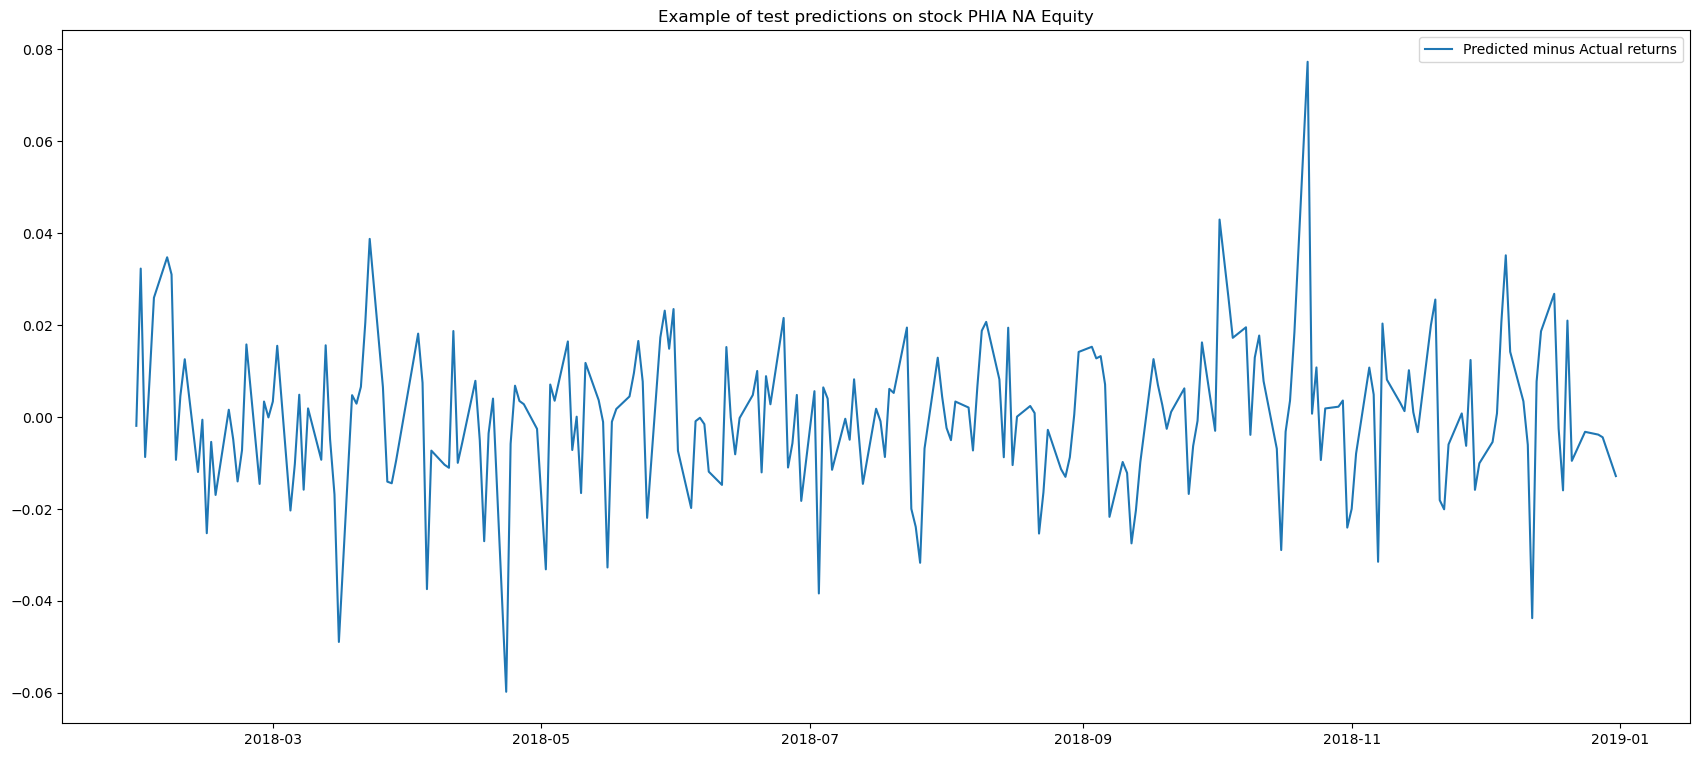

In [153]:
fig, ax = plt.subplots(figsize=(21, 9))

stock_index = 4

#ax.plot(train_days[1:], ret_train.T[stock_index][LOOK_BACK: ], label="Actual", alpha=0.5)
#ax.plot(train_days[1:], train_predictions.T[stock_index], label="Predicted", alpha=0.5)
ax.plot(test_days[1:], test_predictions.T[stock_index] - ret_test.T[stock_index][LOOK_BACK: ], label="Predicted minus Actual returns")

#ax.plot(days_test, ret_test.T[stock_index], label="test")
ax.set_title("Example of test predictions on stock " + prices.columns[stock_index])
ax.legend()
plt.show()

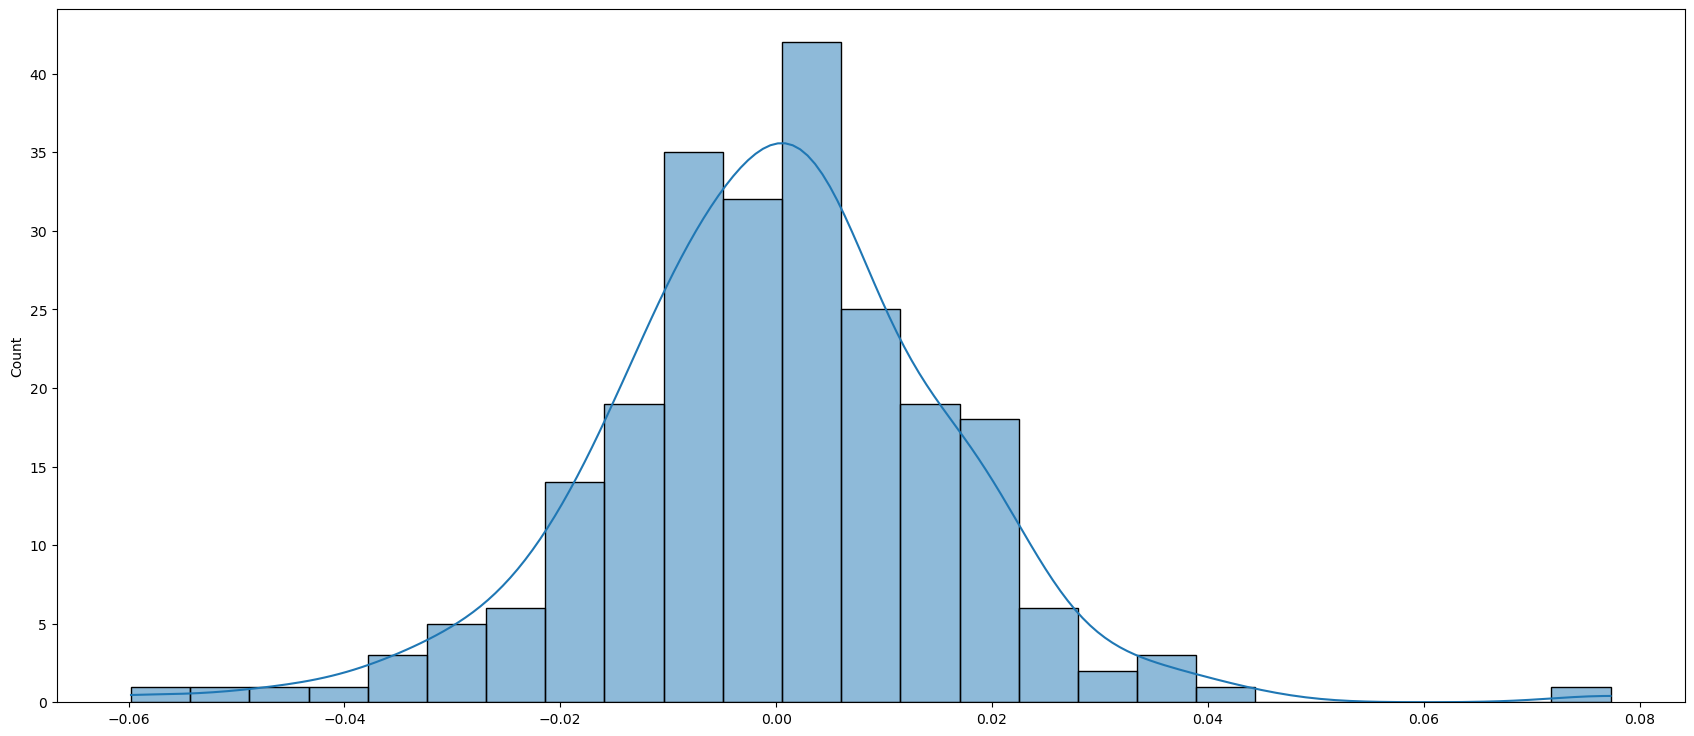

In [154]:
fig, ax = plt.subplots(figsize=(21, 9))

sns.histplot(test_predictions.T[stock_index] - ret_test.T[stock_index][LOOK_BACK: ], kde=True, ax=ax)

plt.show()

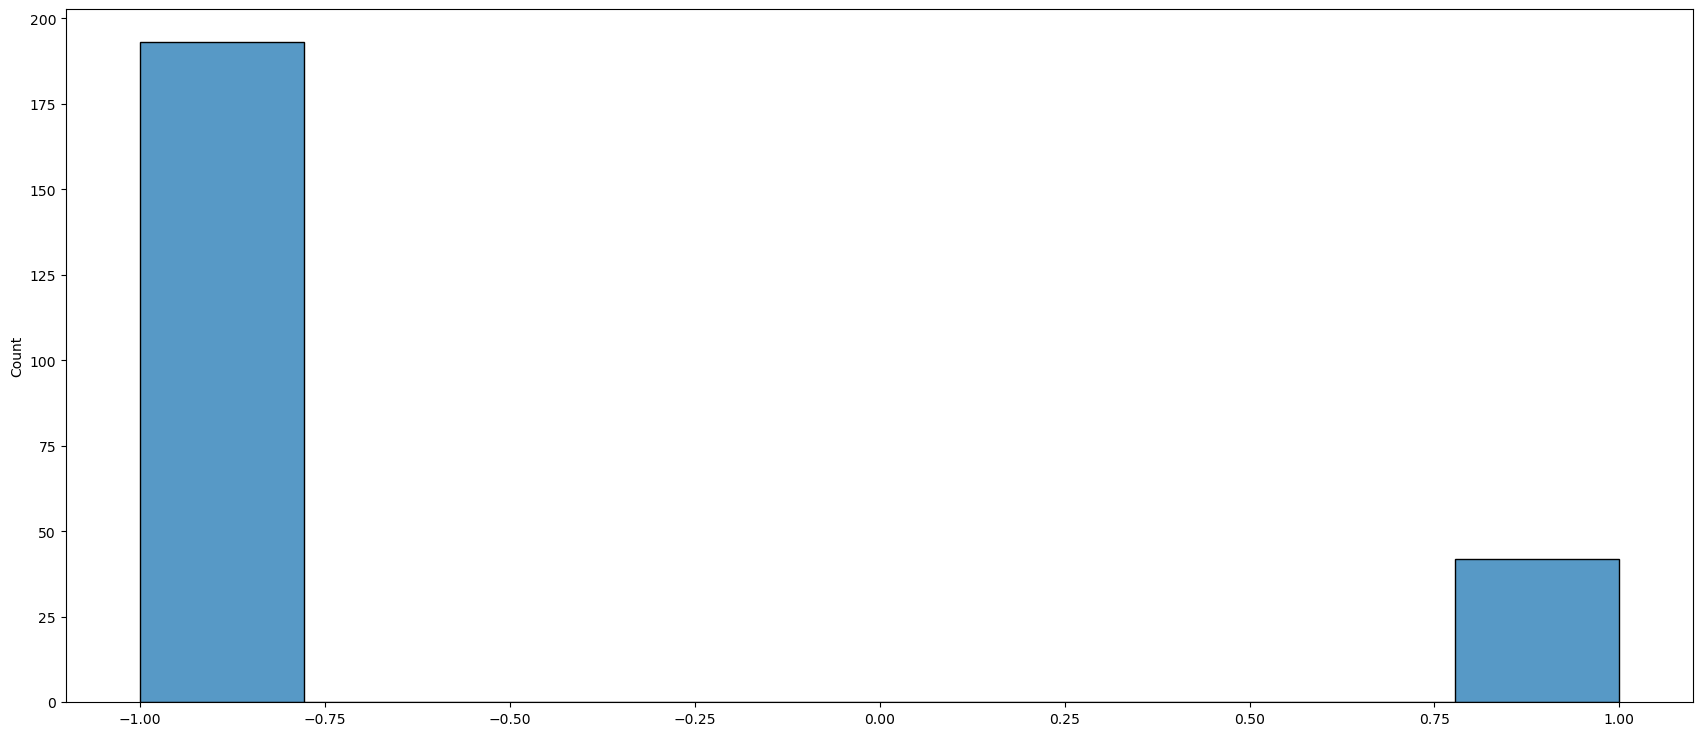

In [155]:
fig, ax = plt.subplots(figsize=(21, 9))

sns.histplot(np.sign((test_predictions.T[stock_index] - ret_test.T[stock_index][LOOK_BACK: ]) * ret_test.T[stock_index][LOOK_BACK: ]),
             ax=ax)

plt.show()

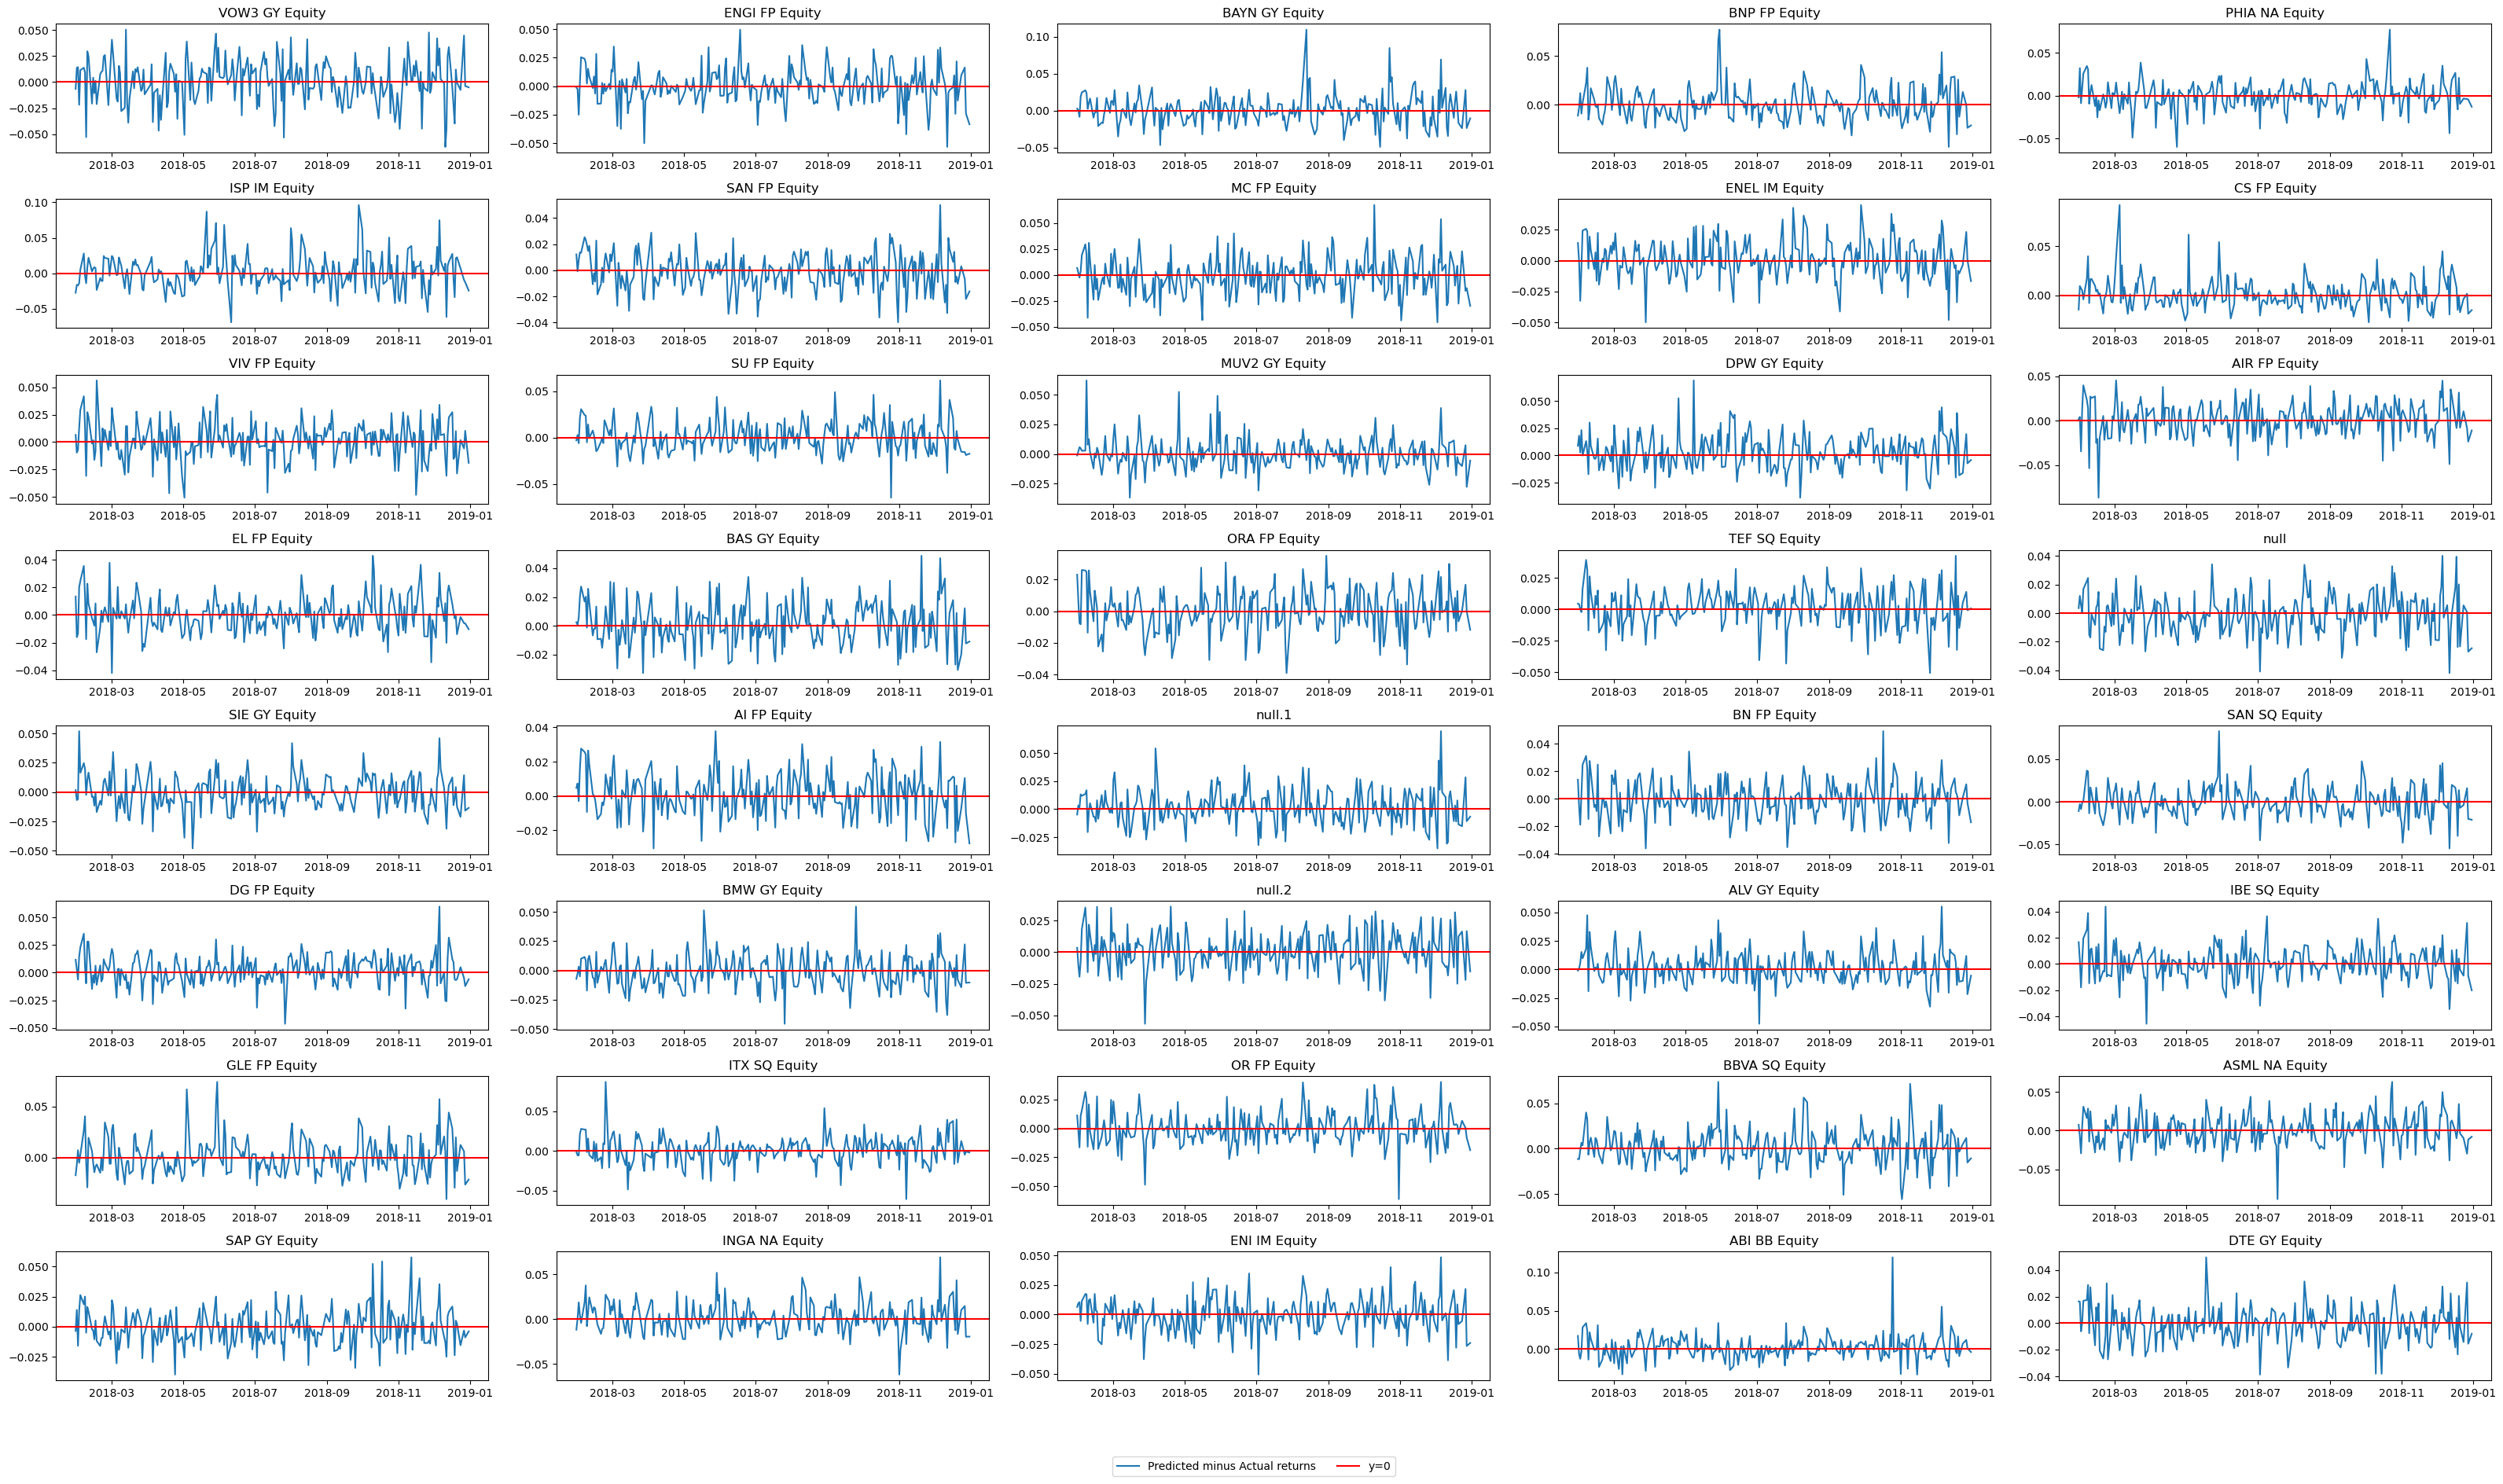

In [156]:
fig, axes = plt.subplots(8, 5, figsize=(32, 18), tight_layout=True)

for i in range(40):
    stock_index = i
    ax = axes[i // 5, i % 5]

    ax.plot(test_days[1:], test_predictions.T[stock_index] - ret_test.T[stock_index][LOOK_BACK: ], label="Predicted minus Actual returns")
    ax.axhline(y=0, color="red", label="y=0")
    ax.set_title(prices.columns[stock_index])

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

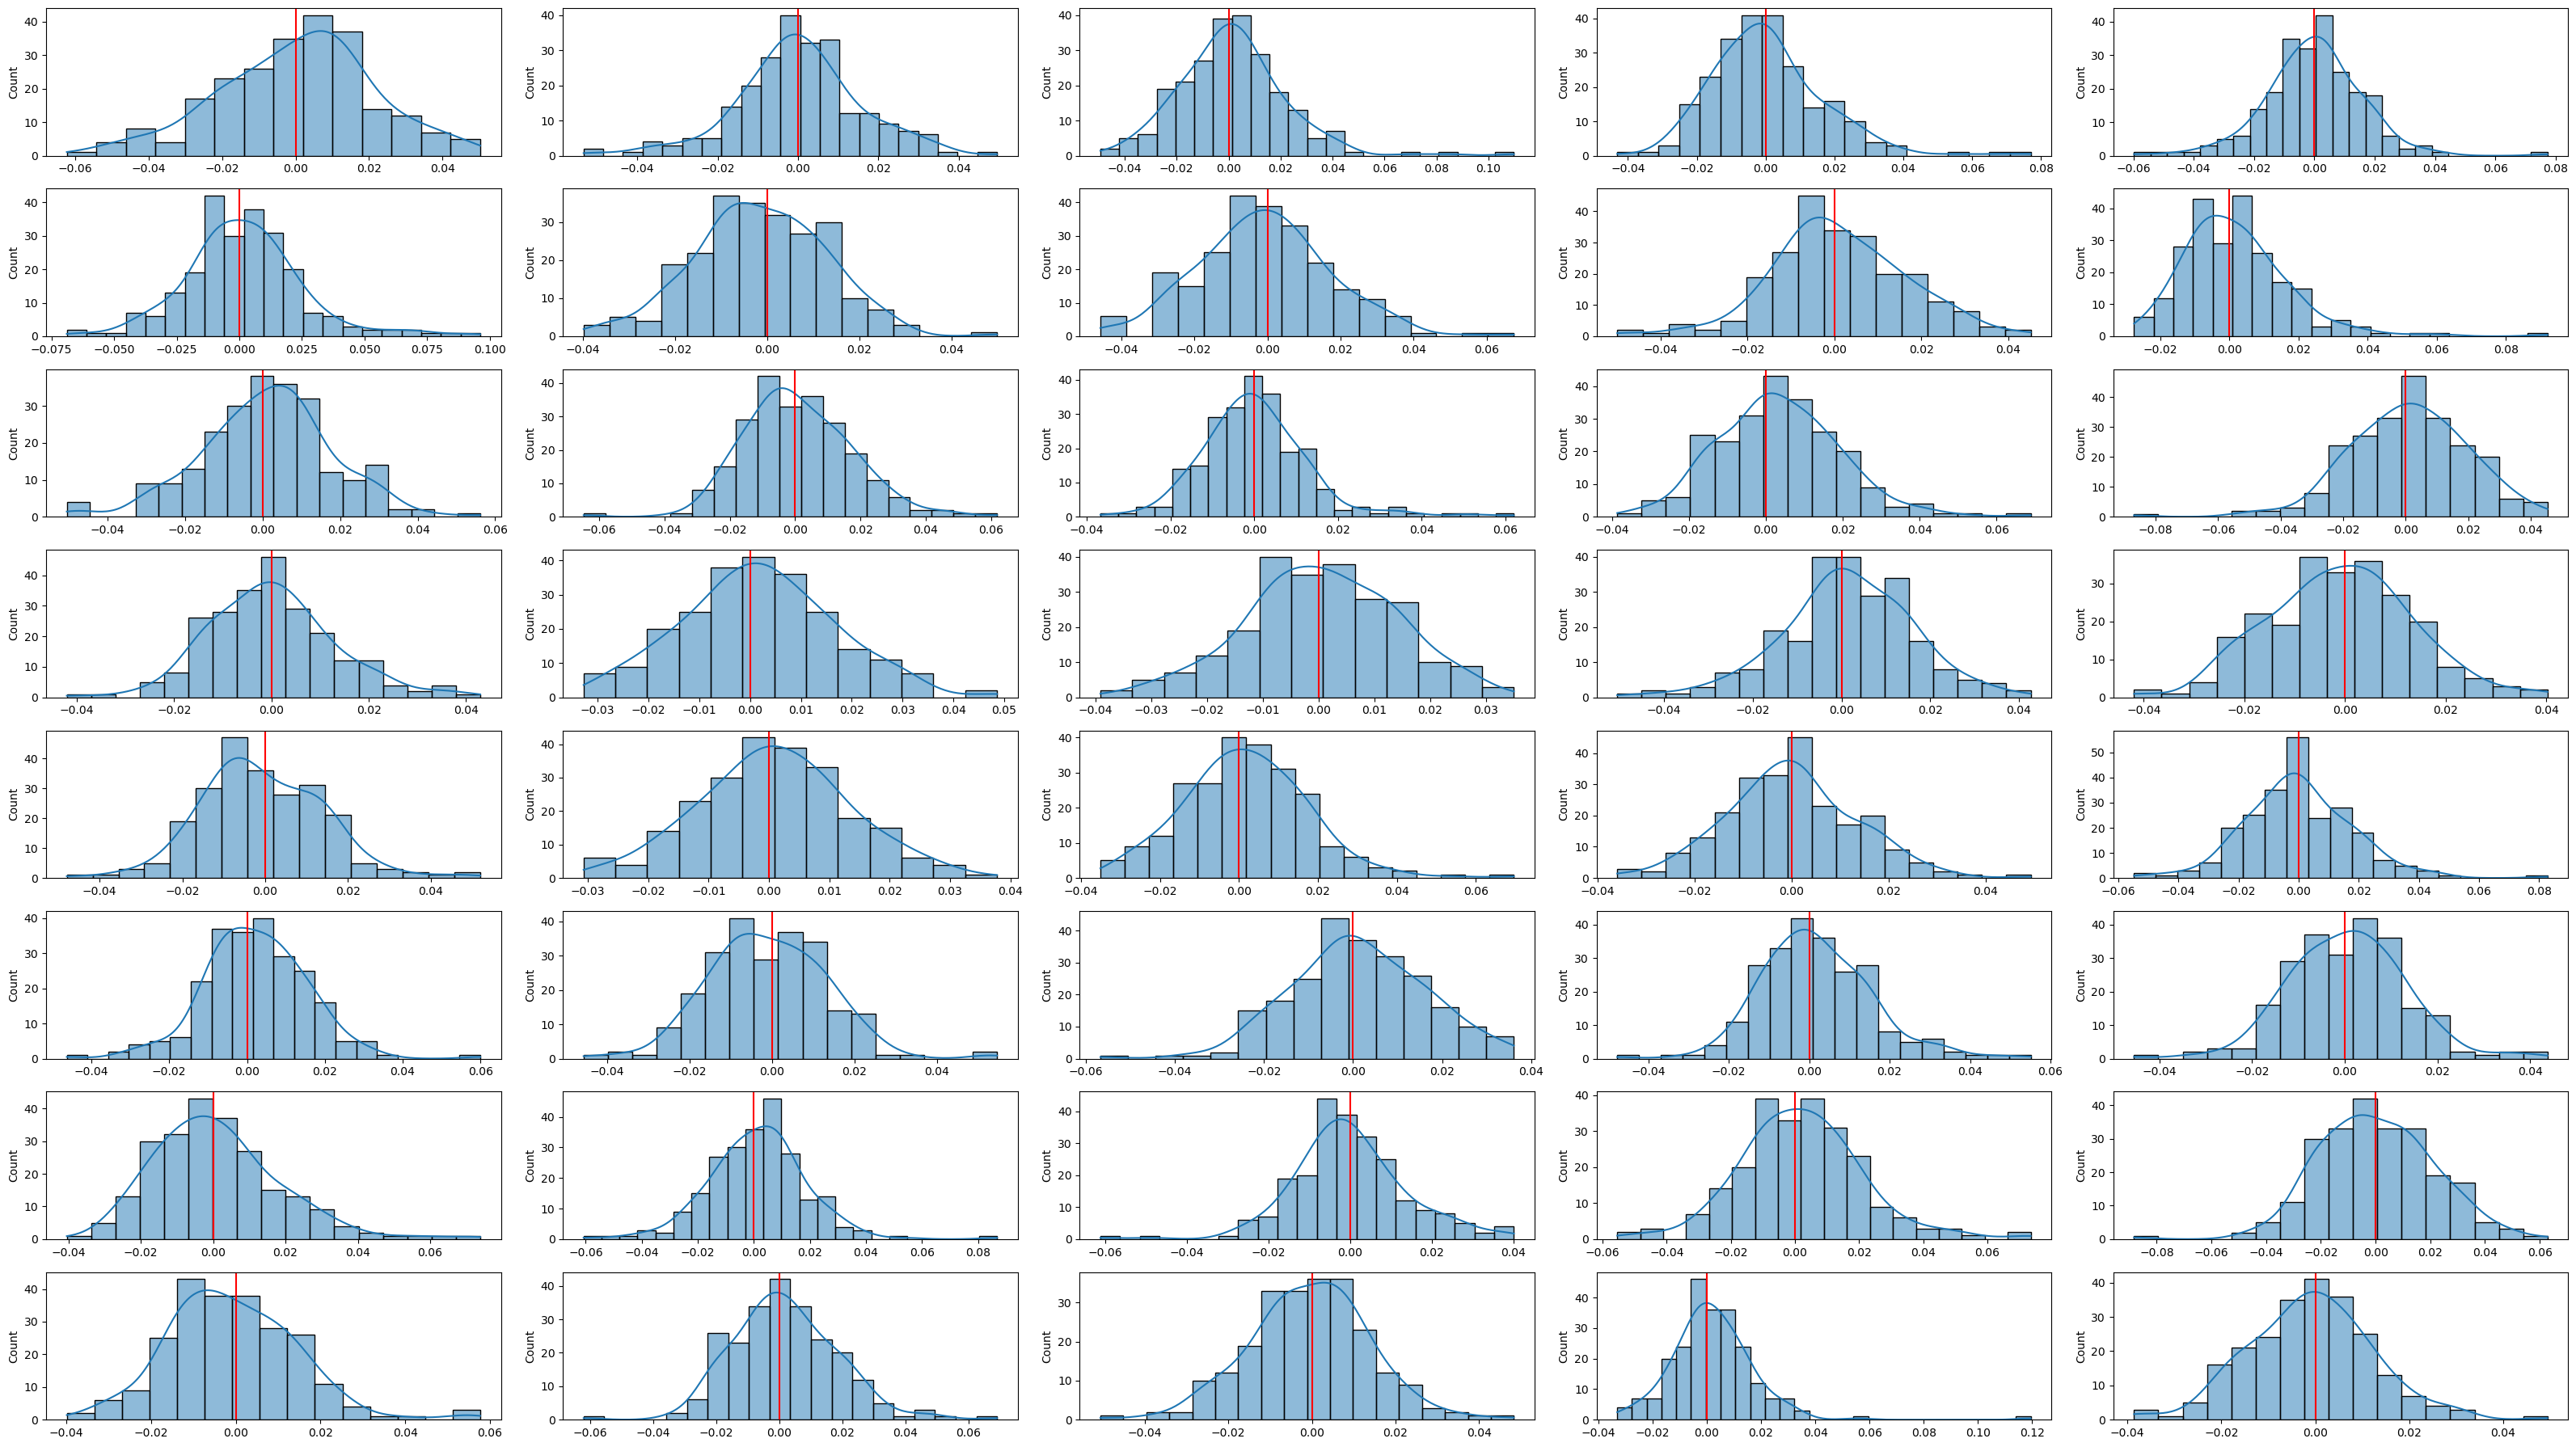

In [157]:
fig, axes = plt.subplots(8, 5, figsize=(32, 18), tight_layout=True)

for i in range(40):
    stock_index = i
    ax = axes[i // 5, i % 5]

    sns.histplot(test_predictions.T[stock_index] - ret_test.T[stock_index][LOOK_BACK: ], kde=True, ax=ax)
    ax.axvline(x=0, color="red", label="x=0")
#handles, labels = axes[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

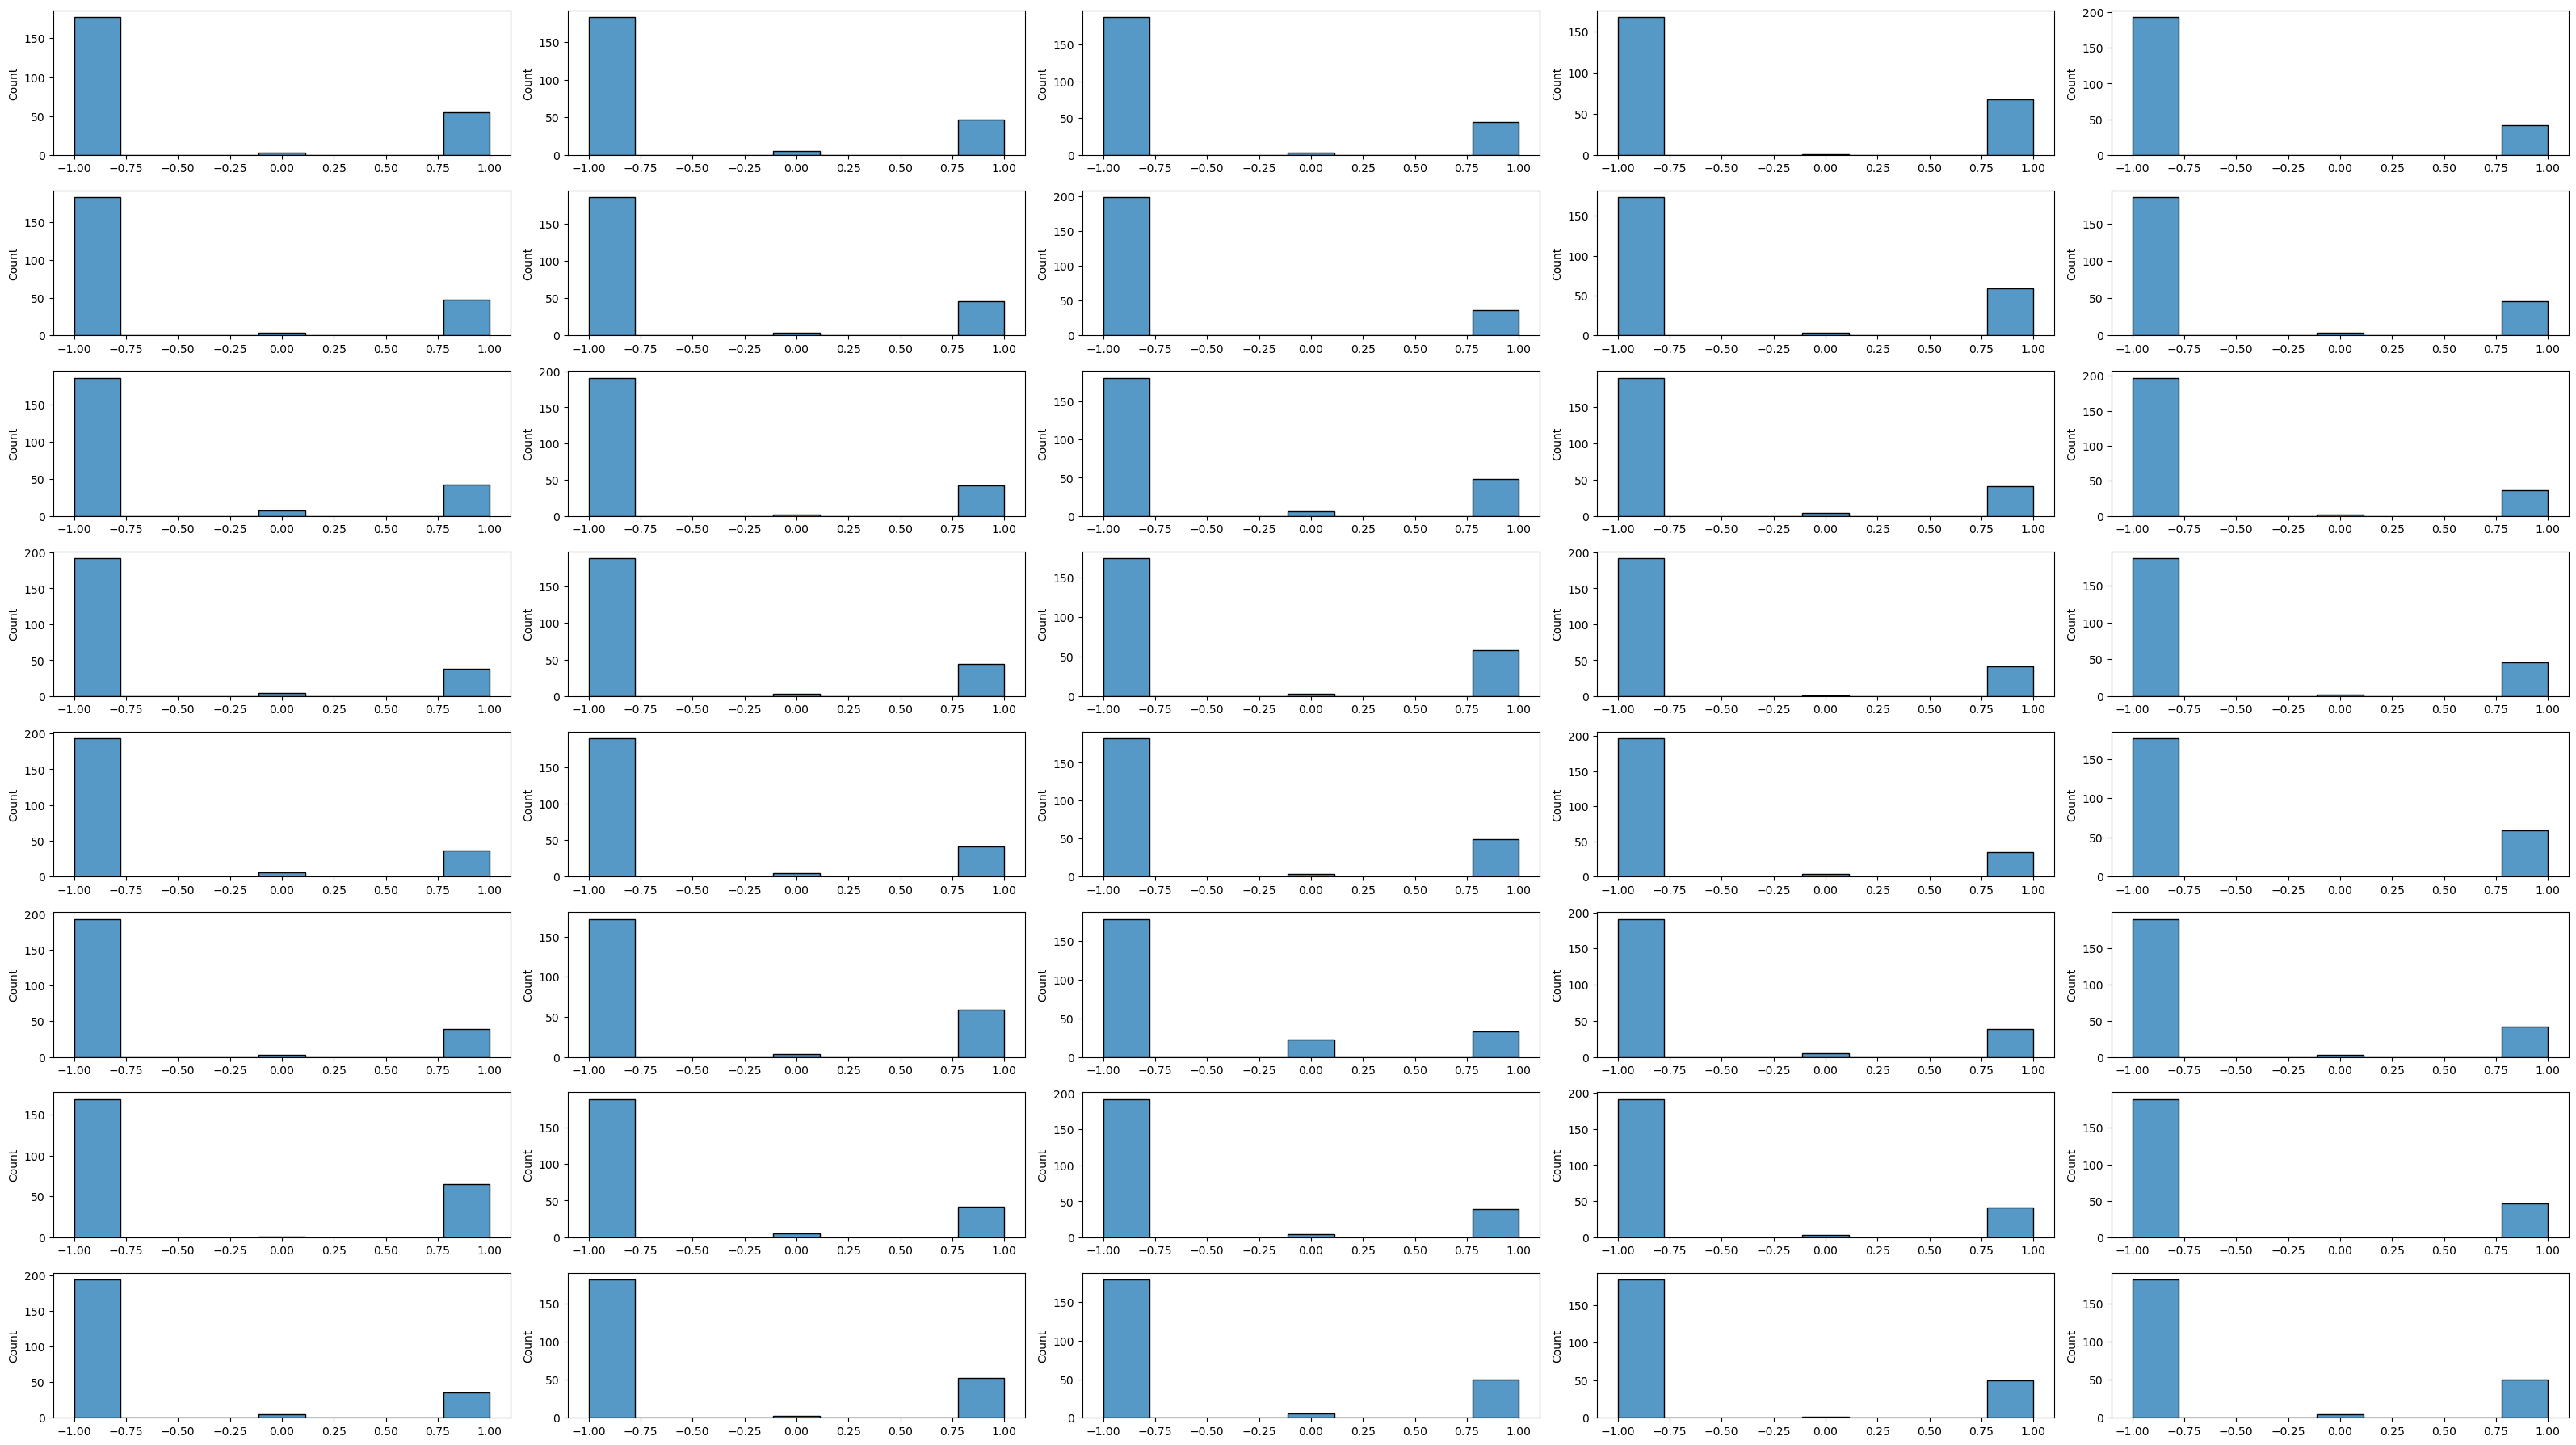

In [158]:
fig, axes = plt.subplots(8, 5, figsize=(32, 18), tight_layout=True)

for i in range(40):
    stock_index = i
    ax = axes[i // 5, i % 5]

    sns.histplot(np.sign((test_predictions.T[stock_index] - ret_test.T[stock_index][LOOK_BACK: ]) * ret_test.T[stock_index][LOOK_BACK: ]),
                ax=ax)
#handles, labels = axes[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

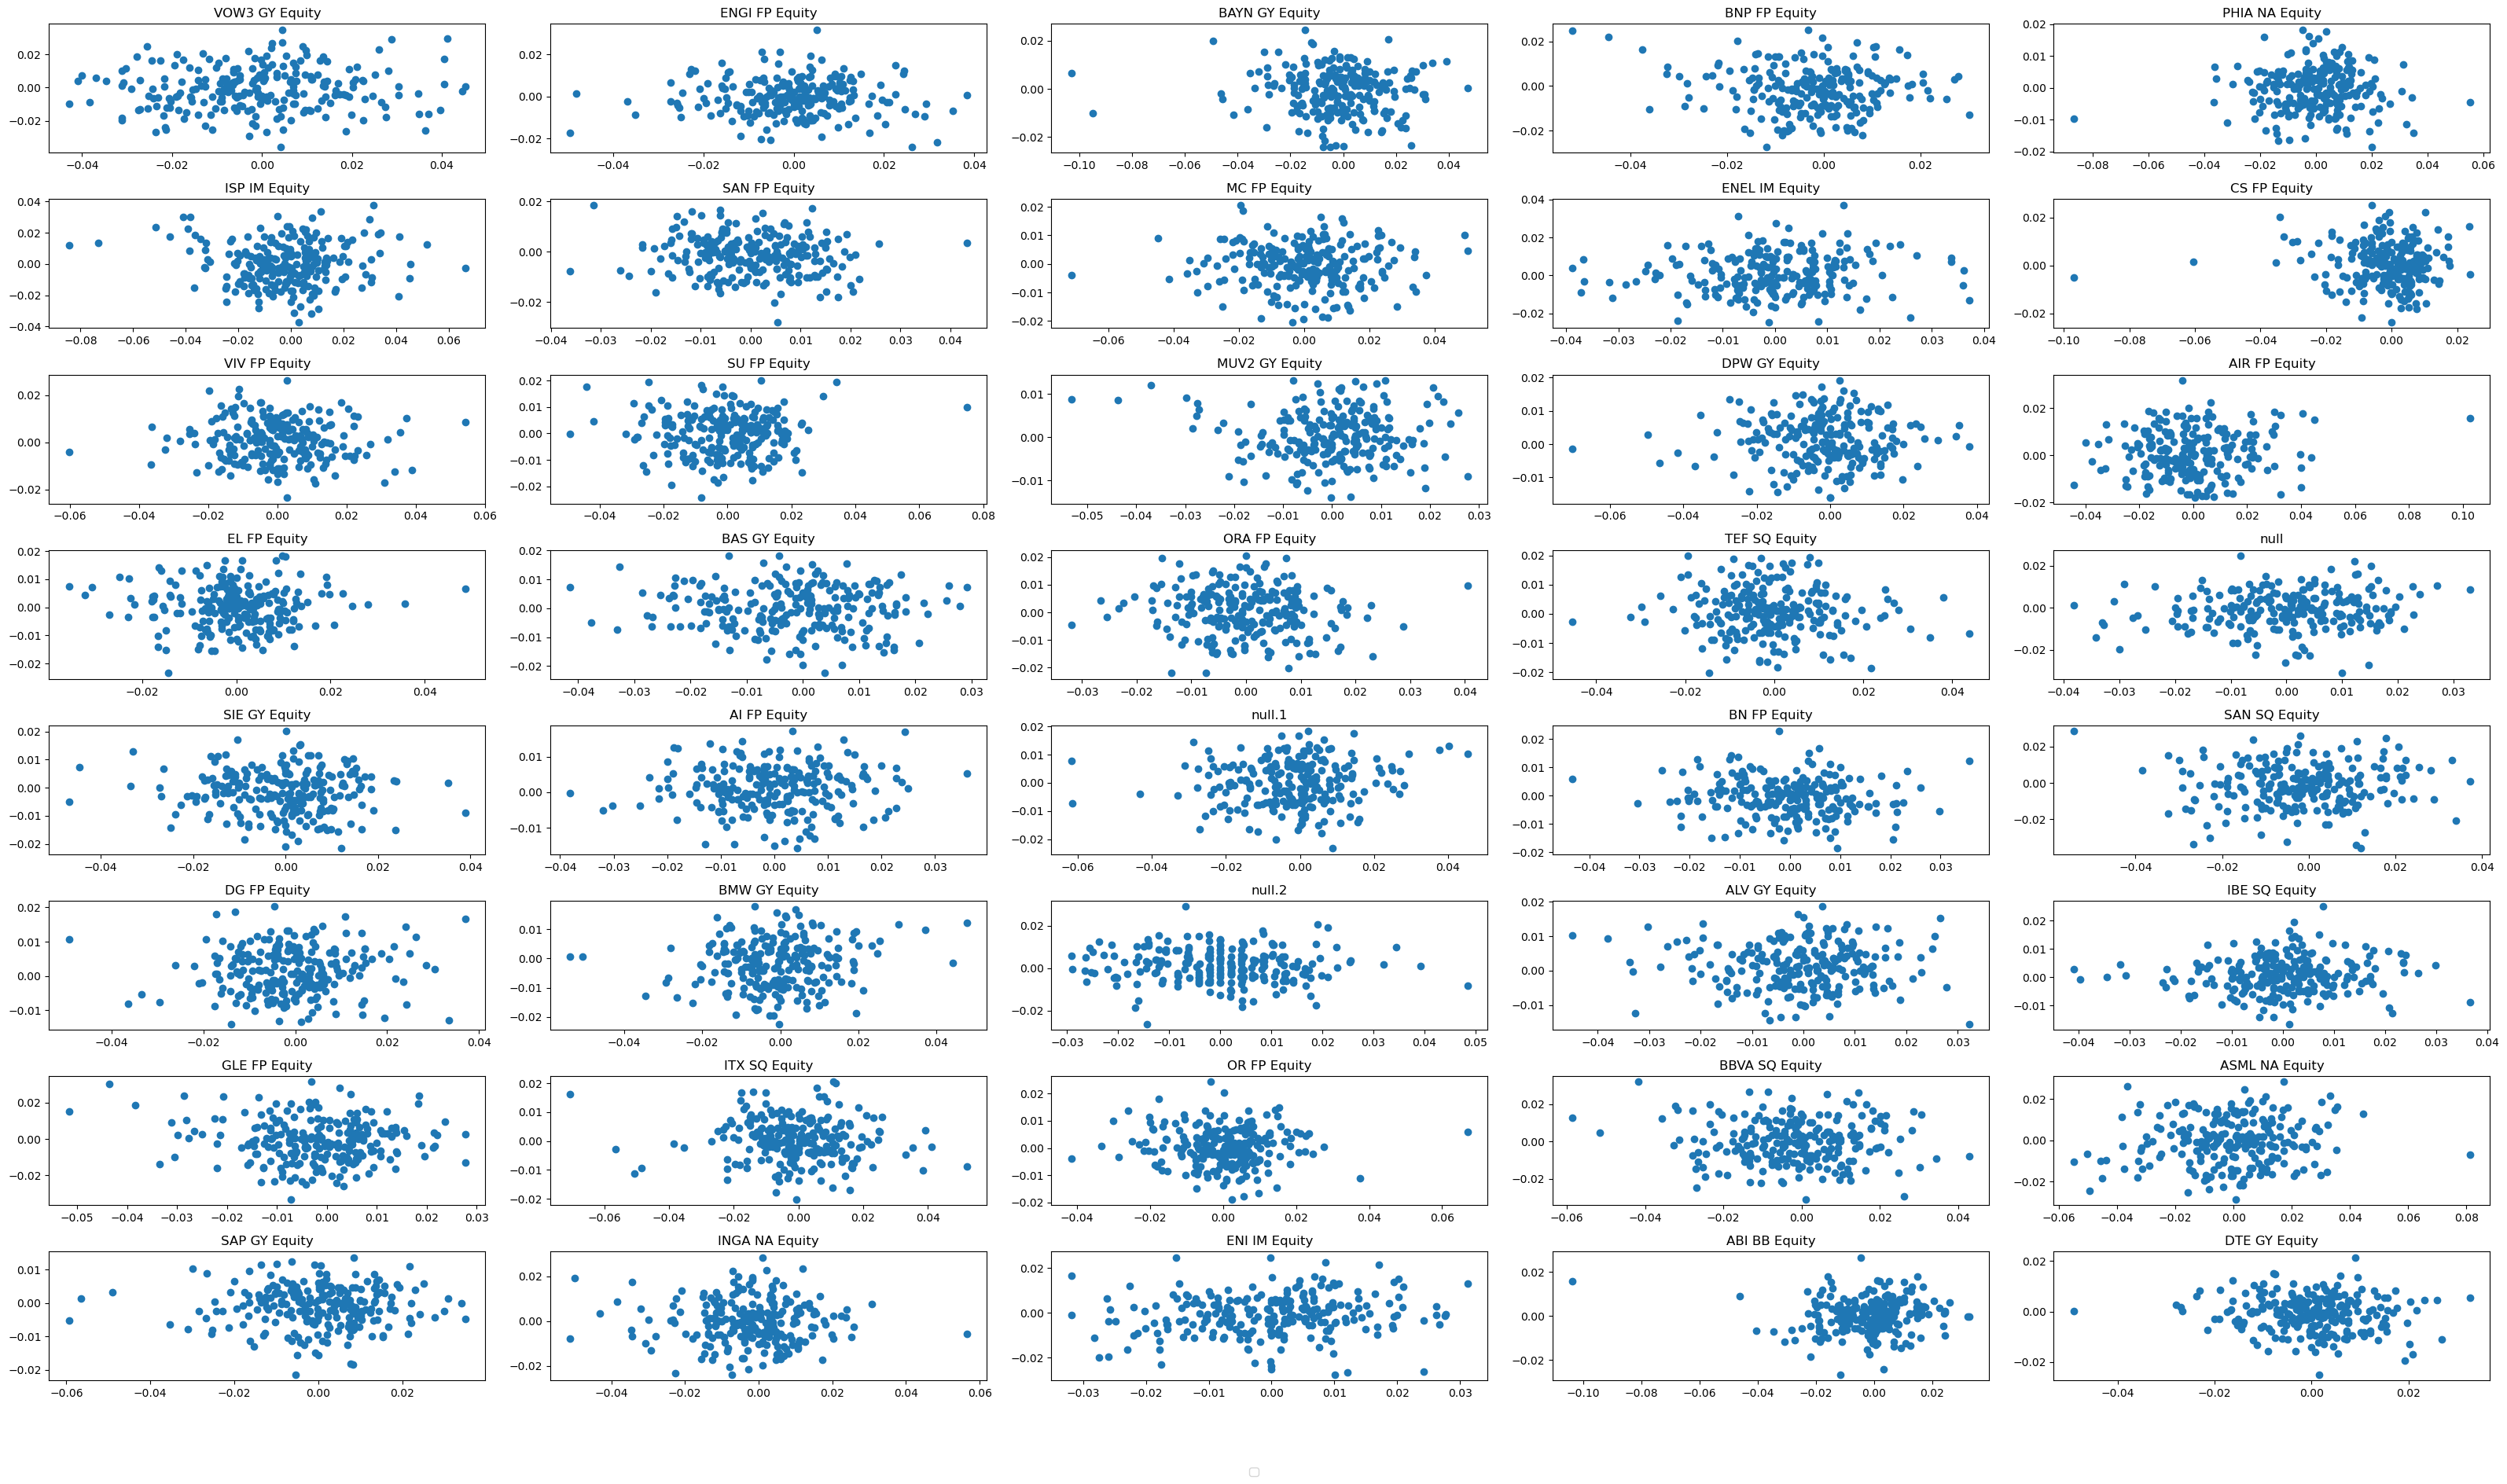

In [163]:
fig, axes = plt.subplots(8, 5, figsize=(32, 18), tight_layout=True)

for i in range(40):
    stock_index = i
    ax = axes[i // 5, i % 5]

    ax.scatter(ret_test.T[stock_index][LOOK_BACK: ], test_predictions.T[stock_index])
    #ax.axhline(y=0, color="red", label="y=0")
    ax.set_title(prices.columns[stock_index])

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()